In [76]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import random
import networkx as nx
import pandas as pd
import seaborn as sns
from itertools import combinations
from datetime import datetime, timedelta

from functions import *
random.seed(0)

**С помощью данных о сенсорном взаимодействии позапускаем эпидемии разного вида и посмотрим, как они будут протекать. Поскольку взаимодействия представлены во времени, а не постоянным графом связей, можно моделировать распространение разных моделей эпидемий, основываясь именно на последовательности контактов. Поскольку длительность контакта не указана, мы будем считать, что при контакте заражение передается с некоторой вероятностью (она будет параметром). Время выздоровления для каждой особи мы будет расчитывать из пуассоновского распределения с некоторым матожиданием (тоже параметр).**

In [3]:
OBS, RFID, OBS_name_mapping = prepare_OBS_and_RFID()
RFID.head()

,t,i,j,DateTime
0,1560396500,1,6,2019-06-13 05:28:00
1,1560396500,1,19,2019-06-13 05:28:00
2,1560396520,6,9,2019-06-13 05:28:00
3,1560396540,7,0,2019-06-13 05:29:00
4,1560396540,1,6,2019-06-13 05:29:00


**Моделируем распространение инфекции**

In [169]:
ST_HEALTHY = 'h'
ST_INFECTED = 'i'
ST_RECOVERED = 'r'


class Node:
    def __init__(self, name: int, status: str, recovery_time: int, infected_time=0, infected_cnt=0):
        self.name = name
        self.status = status
        self.recovery_time = recovery_time
        self.total_infected_time = 0
        self.infected_time = infected_time
        self.infected_cnt = 0
        
    def __str__(self):
        return f'{self.name} {self.status} {self.total_infected_time} {self.infected_cnt}'
    
    def update(self, current_time, epid_type):
        
        if self.status == ST_INFECTED and self.recovery_time < current_time:
            
            self.total_infected_time += self.recovery_time - self.infected_time
            
            if epid_type == 'SIS':
                self.status = ST_HEALTHY
                return np.array([1, -1, 0])
            
            elif epid_type == 'SIR':
                self.status = ST_RECOVERED
                return np.array([0, -1, 1])
        
        return np.array([0, 0, 0])
    
    def infect(self, current_time, recovery_time):
        if self.status == ST_HEALTHY:
            self.status = ST_INFECTED
            self.infected_cnt += 1
            self.recovery_time = recovery_time
            self.infected_time = current_time
            return np.array([-1, 1, 0])
        
        return np.array([0, 0, 0])
    

def its_over(statuses, epid_type):
    nodes_cnt = statuses.sum()
    if statuses[1] == 0:
        return True
    if statuses[1] == nodes_cnt and epid_type == 'SI':
        return True
    return False


def prosecc_epidemy(names, df, col1, col2, col_t, epid_type, p_infect, exp_recover_time, infected_nodes, t_start=None, t_finish=None, verbose=False):
    if t_start is not None:
        df = df[df[col_t] >= t_start]
    if t_finish is not None:
        df = df[df[col_t] <= t_finish]
        
    epidemy_start = df[col_t].min()
    nodes = dict()
    for name in names:
        if name in infected_nodes and epid_type != 'SI':
            nodes[name] = Node(name=name,
                               status=ST_INFECTED,
                               recovery_time=epidemy_start + st.poisson.rvs(mu=exp_recover_time),
                               infected_time=epidemy_start,
                               infected_cnt=1)
            
        elif name in infected_nodes and epid_type == 'SI':
            nodes[name] = Node(name=name,
                               status=ST_INFECTED,
                               recovery_time=df[col_t].max() + 1,
                               infected_time=epidemy_start,
                               infected_cnt=1)
        else:
            nodes[name] = Node(name=name, status=ST_HEALTHY, recovery_time=epidemy_start)

    nodes_cnt = len(names)
    statuses = np.array([len(names) - len(infected_nodes), len(infected_nodes), 0])
    current_time = epidemy_start
    for idx, row in df.iterrows():

        if its_over(statuses, epid_type):
            break
        
        node1, node2 = nodes[row[col1]], nodes[row[col2]]
        current_time = row[col_t]
        
        res1 = node1.update(current_time, epid_type)
        res2 = node2.update(current_time, epid_type)
        statuses += res1
        statuses += res2
        
        if node1.status == ST_INFECTED and node2.status == ST_HEALTHY and random.random() < p_infect:
            res = node2.infect(current_time, current_time + st.poisson.rvs(mu=exp_recover_time))
            statuses += res
    
        if node2.status == ST_INFECTED and node1.status == ST_HEALTHY and random.random() < p_infect:
            res = node1.infect(current_time, current_time + st.poisson.rvs(mu=exp_recover_time))
            statuses += res
        
        if verbose:
            print(statuses)
    
    for node in nodes.values():
        if node.status == ST_INFECTED:
            node.total_infected_time += current_time - node.infected_time
    
    list_answer = [epid_type, infected_nodes[0], p_infect, exp_recover_time, statuses[0], statuses[1], statuses[2], current_time == df[col_t].max(), current_time - epidemy_start]
    list_answer += [node.status for node in nodes.values()]
    list_answer += [node.infected_cnt for node in nodes.values()]
    list_answer += [node.total_infected_time for node in nodes.values()]
    return list_answer

In [170]:
results = []
names = set(RFID['i'].unique()).union(set(RFID['j'].unique()))

for epid_type in ['SI', 'SIR', 'SIS']:
    for p_infect in [0.1 * x for x in range(1, 8)]:
        for exp_recover_time in [3600 * x for x in range(1, 51, 5)]:
            for t_start in [RFID['t'].min() + x * 24 * 3600 for x in range(0, 17, 4)]:
                for start_node in names:
                    print(epid_type, p_infect, exp_recover_time, t_start, start_node)
                    epid_res = prosecc_epidemy(names, RFID, 'i', 'j', 't', epid_type, p_infect, exp_recover_time, [start_node], t_start=t_start, verbose=False)
                    results.append(epid_res)

SI 0.1 3600 1560396500 0
SI 0.1 3600 1560396500 1
SI 0.1 3600 1560396500 2
SI 0.1 3600 1560396500 3
SI 0.1 3600 1560396500 4
SI 0.1 3600 1560396500 6
SI 0.1 3600 1560396500 7
SI 0.1 3600 1560396500 8
SI 0.1 3600 1560396500 9
SI 0.1 3600 1560396500 10
SI 0.1 3600 1560396500 17
SI 0.1 3600 1560396500 18
SI 0.1 3600 1560396500 19
SI 0.1 3600 1560742100 0
SI 0.1 3600 1560742100 1
SI 0.1 3600 1560742100 2
SI 0.1 3600 1560742100 3
SI 0.1 3600 1560742100 4
SI 0.1 3600 1560742100 6
SI 0.1 3600 1560742100 7
SI 0.1 3600 1560742100 8
SI 0.1 3600 1560742100 9
SI 0.1 3600 1560742100 10
SI 0.1 3600 1560742100 17
SI 0.1 3600 1560742100 18
SI 0.1 3600 1560742100 19
SI 0.1 3600 1561087700 0
SI 0.1 3600 1561087700 1
SI 0.1 3600 1561087700 2
SI 0.1 3600 1561087700 3
SI 0.1 3600 1561087700 4
SI 0.1 3600 1561087700 6
SI 0.1 3600 1561087700 7
SI 0.1 3600 1561087700 8
SI 0.1 3600 1561087700 9
SI 0.1 3600 1561087700 10
SI 0.1 3600 1561087700 17
SI 0.1 3600 1561087700 18
SI 0.1 3600 1561087700 19
SI 0.1 3600 1

SI 0.1 75600 1561778900 2
SI 0.1 75600 1561778900 3
SI 0.1 75600 1561778900 4
SI 0.1 75600 1561778900 6
SI 0.1 75600 1561778900 7
SI 0.1 75600 1561778900 8
SI 0.1 75600 1561778900 9
SI 0.1 75600 1561778900 10
SI 0.1 75600 1561778900 17
SI 0.1 75600 1561778900 18
SI 0.1 75600 1561778900 19
SI 0.1 93600 1560396500 0
SI 0.1 93600 1560396500 1
SI 0.1 93600 1560396500 2
SI 0.1 93600 1560396500 3
SI 0.1 93600 1560396500 4
SI 0.1 93600 1560396500 6
SI 0.1 93600 1560396500 7
SI 0.1 93600 1560396500 8
SI 0.1 93600 1560396500 9
SI 0.1 93600 1560396500 10
SI 0.1 93600 1560396500 17
SI 0.1 93600 1560396500 18
SI 0.1 93600 1560396500 19
SI 0.1 93600 1560742100 0
SI 0.1 93600 1560742100 1
SI 0.1 93600 1560742100 2
SI 0.1 93600 1560742100 3
SI 0.1 93600 1560742100 4
SI 0.1 93600 1560742100 6
SI 0.1 93600 1560742100 7
SI 0.1 93600 1560742100 8
SI 0.1 93600 1560742100 9
SI 0.1 93600 1560742100 10
SI 0.1 93600 1560742100 17
SI 0.1 93600 1560742100 18
SI 0.1 93600 1560742100 19
SI 0.1 93600 1561087700 0


SI 0.1 165600 1561087700 7
SI 0.1 165600 1561087700 8
SI 0.1 165600 1561087700 9
SI 0.1 165600 1561087700 10
SI 0.1 165600 1561087700 17
SI 0.1 165600 1561087700 18
SI 0.1 165600 1561087700 19
SI 0.1 165600 1561433300 0
SI 0.1 165600 1561433300 1
SI 0.1 165600 1561433300 2
SI 0.1 165600 1561433300 3
SI 0.1 165600 1561433300 4
SI 0.1 165600 1561433300 6
SI 0.1 165600 1561433300 7
SI 0.1 165600 1561433300 8
SI 0.1 165600 1561433300 9
SI 0.1 165600 1561433300 10
SI 0.1 165600 1561433300 17
SI 0.1 165600 1561433300 18
SI 0.1 165600 1561433300 19
SI 0.1 165600 1561778900 0
SI 0.1 165600 1561778900 1
SI 0.1 165600 1561778900 2
SI 0.1 165600 1561778900 3
SI 0.1 165600 1561778900 4
SI 0.1 165600 1561778900 6
SI 0.1 165600 1561778900 7
SI 0.1 165600 1561778900 8
SI 0.1 165600 1561778900 9
SI 0.1 165600 1561778900 10
SI 0.1 165600 1561778900 17
SI 0.1 165600 1561778900 18
SI 0.1 165600 1561778900 19
SI 0.2 3600 1560396500 0
SI 0.2 3600 1560396500 1
SI 0.2 3600 1560396500 2
SI 0.2 3600 1560396500

SI 0.2 75600 1560742100 8
SI 0.2 75600 1560742100 9
SI 0.2 75600 1560742100 10
SI 0.2 75600 1560742100 17
SI 0.2 75600 1560742100 18
SI 0.2 75600 1560742100 19
SI 0.2 75600 1561087700 0
SI 0.2 75600 1561087700 1
SI 0.2 75600 1561087700 2
SI 0.2 75600 1561087700 3
SI 0.2 75600 1561087700 4
SI 0.2 75600 1561087700 6
SI 0.2 75600 1561087700 7
SI 0.2 75600 1561087700 8
SI 0.2 75600 1561087700 9
SI 0.2 75600 1561087700 10
SI 0.2 75600 1561087700 17
SI 0.2 75600 1561087700 18
SI 0.2 75600 1561087700 19
SI 0.2 75600 1561433300 0
SI 0.2 75600 1561433300 1
SI 0.2 75600 1561433300 2
SI 0.2 75600 1561433300 3
SI 0.2 75600 1561433300 4
SI 0.2 75600 1561433300 6
SI 0.2 75600 1561433300 7
SI 0.2 75600 1561433300 8
SI 0.2 75600 1561433300 9
SI 0.2 75600 1561433300 10
SI 0.2 75600 1561433300 17
SI 0.2 75600 1561433300 18
SI 0.2 75600 1561433300 19
SI 0.2 75600 1561778900 0
SI 0.2 75600 1561778900 1
SI 0.2 75600 1561778900 2
SI 0.2 75600 1561778900 3
SI 0.2 75600 1561778900 4
SI 0.2 75600 1561778900 6


SI 0.2 147600 1561778900 19
SI 0.2 165600 1560396500 0
SI 0.2 165600 1560396500 1
SI 0.2 165600 1560396500 2
SI 0.2 165600 1560396500 3
SI 0.2 165600 1560396500 4
SI 0.2 165600 1560396500 6
SI 0.2 165600 1560396500 7
SI 0.2 165600 1560396500 8
SI 0.2 165600 1560396500 9
SI 0.2 165600 1560396500 10
SI 0.2 165600 1560396500 17
SI 0.2 165600 1560396500 18
SI 0.2 165600 1560396500 19
SI 0.2 165600 1560742100 0
SI 0.2 165600 1560742100 1
SI 0.2 165600 1560742100 2
SI 0.2 165600 1560742100 3
SI 0.2 165600 1560742100 4
SI 0.2 165600 1560742100 6
SI 0.2 165600 1560742100 7
SI 0.2 165600 1560742100 8
SI 0.2 165600 1560742100 9
SI 0.2 165600 1560742100 10
SI 0.2 165600 1560742100 17
SI 0.2 165600 1560742100 18
SI 0.2 165600 1560742100 19
SI 0.2 165600 1561087700 0
SI 0.2 165600 1561087700 1
SI 0.2 165600 1561087700 2
SI 0.2 165600 1561087700 3
SI 0.2 165600 1561087700 4
SI 0.2 165600 1561087700 6
SI 0.2 165600 1561087700 7
SI 0.2 165600 1561087700 8
SI 0.2 165600 1561087700 9
SI 0.2 165600 15610

SI 0.30000000000000004 39600 1560742100 17
SI 0.30000000000000004 39600 1560742100 18
SI 0.30000000000000004 39600 1560742100 19
SI 0.30000000000000004 39600 1561087700 0
SI 0.30000000000000004 39600 1561087700 1
SI 0.30000000000000004 39600 1561087700 2
SI 0.30000000000000004 39600 1561087700 3
SI 0.30000000000000004 39600 1561087700 4
SI 0.30000000000000004 39600 1561087700 6
SI 0.30000000000000004 39600 1561087700 7
SI 0.30000000000000004 39600 1561087700 8
SI 0.30000000000000004 39600 1561087700 9
SI 0.30000000000000004 39600 1561087700 10
SI 0.30000000000000004 39600 1561087700 17
SI 0.30000000000000004 39600 1561087700 18
SI 0.30000000000000004 39600 1561087700 19
SI 0.30000000000000004 39600 1561433300 0
SI 0.30000000000000004 39600 1561433300 1
SI 0.30000000000000004 39600 1561433300 2
SI 0.30000000000000004 39600 1561433300 3
SI 0.30000000000000004 39600 1561433300 4
SI 0.30000000000000004 39600 1561433300 6
SI 0.30000000000000004 39600 1561433300 7
SI 0.30000000000000004 3960

SI 0.30000000000000004 93600 1560742100 10
SI 0.30000000000000004 93600 1560742100 17
SI 0.30000000000000004 93600 1560742100 18
SI 0.30000000000000004 93600 1560742100 19
SI 0.30000000000000004 93600 1561087700 0
SI 0.30000000000000004 93600 1561087700 1
SI 0.30000000000000004 93600 1561087700 2
SI 0.30000000000000004 93600 1561087700 3
SI 0.30000000000000004 93600 1561087700 4
SI 0.30000000000000004 93600 1561087700 6
SI 0.30000000000000004 93600 1561087700 7
SI 0.30000000000000004 93600 1561087700 8
SI 0.30000000000000004 93600 1561087700 9
SI 0.30000000000000004 93600 1561087700 10
SI 0.30000000000000004 93600 1561087700 17
SI 0.30000000000000004 93600 1561087700 18
SI 0.30000000000000004 93600 1561087700 19
SI 0.30000000000000004 93600 1561433300 0
SI 0.30000000000000004 93600 1561433300 1
SI 0.30000000000000004 93600 1561433300 2
SI 0.30000000000000004 93600 1561433300 3
SI 0.30000000000000004 93600 1561433300 4
SI 0.30000000000000004 93600 1561433300 6
SI 0.30000000000000004 936

SI 0.30000000000000004 147600 1560742100 6
SI 0.30000000000000004 147600 1560742100 7
SI 0.30000000000000004 147600 1560742100 8
SI 0.30000000000000004 147600 1560742100 9
SI 0.30000000000000004 147600 1560742100 10
SI 0.30000000000000004 147600 1560742100 17
SI 0.30000000000000004 147600 1560742100 18
SI 0.30000000000000004 147600 1560742100 19
SI 0.30000000000000004 147600 1561087700 0
SI 0.30000000000000004 147600 1561087700 1
SI 0.30000000000000004 147600 1561087700 2
SI 0.30000000000000004 147600 1561087700 3
SI 0.30000000000000004 147600 1561087700 4
SI 0.30000000000000004 147600 1561087700 6
SI 0.30000000000000004 147600 1561087700 7
SI 0.30000000000000004 147600 1561087700 8
SI 0.30000000000000004 147600 1561087700 9
SI 0.30000000000000004 147600 1561087700 10
SI 0.30000000000000004 147600 1561087700 17
SI 0.30000000000000004 147600 1561087700 18
SI 0.30000000000000004 147600 1561087700 19
SI 0.30000000000000004 147600 1561433300 0
SI 0.30000000000000004 147600 1561433300 1
SI 

SI 0.4 39600 1560396500 0
SI 0.4 39600 1560396500 1
SI 0.4 39600 1560396500 2
SI 0.4 39600 1560396500 3
SI 0.4 39600 1560396500 4
SI 0.4 39600 1560396500 6
SI 0.4 39600 1560396500 7
SI 0.4 39600 1560396500 8
SI 0.4 39600 1560396500 9
SI 0.4 39600 1560396500 10
SI 0.4 39600 1560396500 17
SI 0.4 39600 1560396500 18
SI 0.4 39600 1560396500 19
SI 0.4 39600 1560742100 0
SI 0.4 39600 1560742100 1
SI 0.4 39600 1560742100 2
SI 0.4 39600 1560742100 3
SI 0.4 39600 1560742100 4
SI 0.4 39600 1560742100 6
SI 0.4 39600 1560742100 7
SI 0.4 39600 1560742100 8
SI 0.4 39600 1560742100 9
SI 0.4 39600 1560742100 10
SI 0.4 39600 1560742100 17
SI 0.4 39600 1560742100 18
SI 0.4 39600 1560742100 19
SI 0.4 39600 1561087700 0
SI 0.4 39600 1561087700 1
SI 0.4 39600 1561087700 2
SI 0.4 39600 1561087700 3
SI 0.4 39600 1561087700 4
SI 0.4 39600 1561087700 6
SI 0.4 39600 1561087700 7
SI 0.4 39600 1561087700 8
SI 0.4 39600 1561087700 9
SI 0.4 39600 1561087700 10
SI 0.4 39600 1561087700 17
SI 0.4 39600 1561087700 18
S

SI 0.4 111600 1561433300 19
SI 0.4 111600 1561778900 0
SI 0.4 111600 1561778900 1
SI 0.4 111600 1561778900 2
SI 0.4 111600 1561778900 3
SI 0.4 111600 1561778900 4
SI 0.4 111600 1561778900 6
SI 0.4 111600 1561778900 7
SI 0.4 111600 1561778900 8
SI 0.4 111600 1561778900 9
SI 0.4 111600 1561778900 10
SI 0.4 111600 1561778900 17
SI 0.4 111600 1561778900 18
SI 0.4 111600 1561778900 19
SI 0.4 129600 1560396500 0
SI 0.4 129600 1560396500 1
SI 0.4 129600 1560396500 2
SI 0.4 129600 1560396500 3
SI 0.4 129600 1560396500 4
SI 0.4 129600 1560396500 6
SI 0.4 129600 1560396500 7
SI 0.4 129600 1560396500 8
SI 0.4 129600 1560396500 9
SI 0.4 129600 1560396500 10
SI 0.4 129600 1560396500 17
SI 0.4 129600 1560396500 18
SI 0.4 129600 1560396500 19
SI 0.4 129600 1560742100 0
SI 0.4 129600 1560742100 1
SI 0.4 129600 1560742100 2
SI 0.4 129600 1560742100 3
SI 0.4 129600 1560742100 4
SI 0.4 129600 1560742100 6
SI 0.4 129600 1560742100 7
SI 0.4 129600 1560742100 8
SI 0.4 129600 1560742100 9
SI 0.4 129600 15607

SI 0.5 21600 1561087700 8
SI 0.5 21600 1561087700 9
SI 0.5 21600 1561087700 10
SI 0.5 21600 1561087700 17
SI 0.5 21600 1561087700 18
SI 0.5 21600 1561087700 19
SI 0.5 21600 1561433300 0
SI 0.5 21600 1561433300 1
SI 0.5 21600 1561433300 2
SI 0.5 21600 1561433300 3
SI 0.5 21600 1561433300 4
SI 0.5 21600 1561433300 6
SI 0.5 21600 1561433300 7
SI 0.5 21600 1561433300 8
SI 0.5 21600 1561433300 9
SI 0.5 21600 1561433300 10
SI 0.5 21600 1561433300 17
SI 0.5 21600 1561433300 18
SI 0.5 21600 1561433300 19
SI 0.5 21600 1561778900 0
SI 0.5 21600 1561778900 1
SI 0.5 21600 1561778900 2
SI 0.5 21600 1561778900 3
SI 0.5 21600 1561778900 4
SI 0.5 21600 1561778900 6
SI 0.5 21600 1561778900 7
SI 0.5 21600 1561778900 8
SI 0.5 21600 1561778900 9
SI 0.5 21600 1561778900 10
SI 0.5 21600 1561778900 17
SI 0.5 21600 1561778900 18
SI 0.5 21600 1561778900 19
SI 0.5 39600 1560396500 0
SI 0.5 39600 1560396500 1
SI 0.5 39600 1560396500 2
SI 0.5 39600 1560396500 3
SI 0.5 39600 1560396500 4
SI 0.5 39600 1560396500 6


SI 0.5 111600 1560742100 7
SI 0.5 111600 1560742100 8
SI 0.5 111600 1560742100 9
SI 0.5 111600 1560742100 10
SI 0.5 111600 1560742100 17
SI 0.5 111600 1560742100 18
SI 0.5 111600 1560742100 19
SI 0.5 111600 1561087700 0
SI 0.5 111600 1561087700 1
SI 0.5 111600 1561087700 2
SI 0.5 111600 1561087700 3
SI 0.5 111600 1561087700 4
SI 0.5 111600 1561087700 6
SI 0.5 111600 1561087700 7
SI 0.5 111600 1561087700 8
SI 0.5 111600 1561087700 9
SI 0.5 111600 1561087700 10
SI 0.5 111600 1561087700 17
SI 0.5 111600 1561087700 18
SI 0.5 111600 1561087700 19
SI 0.5 111600 1561433300 0
SI 0.5 111600 1561433300 1
SI 0.5 111600 1561433300 2
SI 0.5 111600 1561433300 3
SI 0.5 111600 1561433300 4
SI 0.5 111600 1561433300 6
SI 0.5 111600 1561433300 7
SI 0.5 111600 1561433300 8
SI 0.5 111600 1561433300 9
SI 0.5 111600 1561433300 10
SI 0.5 111600 1561433300 17
SI 0.5 111600 1561433300 18
SI 0.5 111600 1561433300 19
SI 0.5 111600 1561778900 0
SI 0.5 111600 1561778900 1
SI 0.5 111600 1561778900 2
SI 0.5 111600 15

SI 0.6000000000000001 3600 1561433300 1
SI 0.6000000000000001 3600 1561433300 2
SI 0.6000000000000001 3600 1561433300 3
SI 0.6000000000000001 3600 1561433300 4
SI 0.6000000000000001 3600 1561433300 6
SI 0.6000000000000001 3600 1561433300 7
SI 0.6000000000000001 3600 1561433300 8
SI 0.6000000000000001 3600 1561433300 9
SI 0.6000000000000001 3600 1561433300 10
SI 0.6000000000000001 3600 1561433300 17
SI 0.6000000000000001 3600 1561433300 18
SI 0.6000000000000001 3600 1561433300 19
SI 0.6000000000000001 3600 1561778900 0
SI 0.6000000000000001 3600 1561778900 1
SI 0.6000000000000001 3600 1561778900 2
SI 0.6000000000000001 3600 1561778900 3
SI 0.6000000000000001 3600 1561778900 4
SI 0.6000000000000001 3600 1561778900 6
SI 0.6000000000000001 3600 1561778900 7
SI 0.6000000000000001 3600 1561778900 8
SI 0.6000000000000001 3600 1561778900 9
SI 0.6000000000000001 3600 1561778900 10
SI 0.6000000000000001 3600 1561778900 17
SI 0.6000000000000001 3600 1561778900 18
SI 0.6000000000000001 3600 156177

SI 0.6000000000000001 57600 1561433300 6
SI 0.6000000000000001 57600 1561433300 7
SI 0.6000000000000001 57600 1561433300 8
SI 0.6000000000000001 57600 1561433300 9
SI 0.6000000000000001 57600 1561433300 10
SI 0.6000000000000001 57600 1561433300 17
SI 0.6000000000000001 57600 1561433300 18
SI 0.6000000000000001 57600 1561433300 19
SI 0.6000000000000001 57600 1561778900 0
SI 0.6000000000000001 57600 1561778900 1
SI 0.6000000000000001 57600 1561778900 2
SI 0.6000000000000001 57600 1561778900 3
SI 0.6000000000000001 57600 1561778900 4
SI 0.6000000000000001 57600 1561778900 6
SI 0.6000000000000001 57600 1561778900 7
SI 0.6000000000000001 57600 1561778900 8
SI 0.6000000000000001 57600 1561778900 9
SI 0.6000000000000001 57600 1561778900 10
SI 0.6000000000000001 57600 1561778900 17
SI 0.6000000000000001 57600 1561778900 18
SI 0.6000000000000001 57600 1561778900 19
SI 0.6000000000000001 75600 1560396500 0
SI 0.6000000000000001 75600 1560396500 1
SI 0.6000000000000001 75600 1560396500 2
SI 0.600

SI 0.6000000000000001 111600 1561433300 10
SI 0.6000000000000001 111600 1561433300 17
SI 0.6000000000000001 111600 1561433300 18
SI 0.6000000000000001 111600 1561433300 19
SI 0.6000000000000001 111600 1561778900 0
SI 0.6000000000000001 111600 1561778900 1
SI 0.6000000000000001 111600 1561778900 2
SI 0.6000000000000001 111600 1561778900 3
SI 0.6000000000000001 111600 1561778900 4
SI 0.6000000000000001 111600 1561778900 6
SI 0.6000000000000001 111600 1561778900 7
SI 0.6000000000000001 111600 1561778900 8
SI 0.6000000000000001 111600 1561778900 9
SI 0.6000000000000001 111600 1561778900 10
SI 0.6000000000000001 111600 1561778900 17
SI 0.6000000000000001 111600 1561778900 18
SI 0.6000000000000001 111600 1561778900 19
SI 0.6000000000000001 129600 1560396500 0
SI 0.6000000000000001 129600 1560396500 1
SI 0.6000000000000001 129600 1560396500 2
SI 0.6000000000000001 129600 1560396500 3
SI 0.6000000000000001 129600 1560396500 4
SI 0.6000000000000001 129600 1560396500 6
SI 0.6000000000000001 1296

SI 0.6000000000000001 165600 1561433300 9
SI 0.6000000000000001 165600 1561433300 10
SI 0.6000000000000001 165600 1561433300 17
SI 0.6000000000000001 165600 1561433300 18
SI 0.6000000000000001 165600 1561433300 19
SI 0.6000000000000001 165600 1561778900 0
SI 0.6000000000000001 165600 1561778900 1
SI 0.6000000000000001 165600 1561778900 2
SI 0.6000000000000001 165600 1561778900 3
SI 0.6000000000000001 165600 1561778900 4
SI 0.6000000000000001 165600 1561778900 6
SI 0.6000000000000001 165600 1561778900 7
SI 0.6000000000000001 165600 1561778900 8
SI 0.6000000000000001 165600 1561778900 9
SI 0.6000000000000001 165600 1561778900 10
SI 0.6000000000000001 165600 1561778900 17
SI 0.6000000000000001 165600 1561778900 18
SI 0.6000000000000001 165600 1561778900 19
SI 0.7000000000000001 3600 1560396500 0
SI 0.7000000000000001 3600 1560396500 1
SI 0.7000000000000001 3600 1560396500 2
SI 0.7000000000000001 3600 1560396500 3
SI 0.7000000000000001 3600 1560396500 4
SI 0.7000000000000001 3600 156039650

SI 0.7000000000000001 39600 1561778900 0
SI 0.7000000000000001 39600 1561778900 1
SI 0.7000000000000001 39600 1561778900 2
SI 0.7000000000000001 39600 1561778900 3
SI 0.7000000000000001 39600 1561778900 4
SI 0.7000000000000001 39600 1561778900 6
SI 0.7000000000000001 39600 1561778900 7
SI 0.7000000000000001 39600 1561778900 8
SI 0.7000000000000001 39600 1561778900 9
SI 0.7000000000000001 39600 1561778900 10
SI 0.7000000000000001 39600 1561778900 17
SI 0.7000000000000001 39600 1561778900 18
SI 0.7000000000000001 39600 1561778900 19
SI 0.7000000000000001 57600 1560396500 0
SI 0.7000000000000001 57600 1560396500 1
SI 0.7000000000000001 57600 1560396500 2
SI 0.7000000000000001 57600 1560396500 3
SI 0.7000000000000001 57600 1560396500 4
SI 0.7000000000000001 57600 1560396500 6
SI 0.7000000000000001 57600 1560396500 7
SI 0.7000000000000001 57600 1560396500 8
SI 0.7000000000000001 57600 1560396500 9
SI 0.7000000000000001 57600 1560396500 10
SI 0.7000000000000001 57600 1560396500 17
SI 0.70000

SI 0.7000000000000001 93600 1561778900 4
SI 0.7000000000000001 93600 1561778900 6
SI 0.7000000000000001 93600 1561778900 7
SI 0.7000000000000001 93600 1561778900 8
SI 0.7000000000000001 93600 1561778900 9
SI 0.7000000000000001 93600 1561778900 10
SI 0.7000000000000001 93600 1561778900 17
SI 0.7000000000000001 93600 1561778900 18
SI 0.7000000000000001 93600 1561778900 19
SI 0.7000000000000001 111600 1560396500 0
SI 0.7000000000000001 111600 1560396500 1
SI 0.7000000000000001 111600 1560396500 2
SI 0.7000000000000001 111600 1560396500 3
SI 0.7000000000000001 111600 1560396500 4
SI 0.7000000000000001 111600 1560396500 6
SI 0.7000000000000001 111600 1560396500 7
SI 0.7000000000000001 111600 1560396500 8
SI 0.7000000000000001 111600 1560396500 9
SI 0.7000000000000001 111600 1560396500 10
SI 0.7000000000000001 111600 1560396500 17
SI 0.7000000000000001 111600 1560396500 18
SI 0.7000000000000001 111600 1560396500 19
SI 0.7000000000000001 111600 1560742100 0
SI 0.7000000000000001 111600 156074

SI 0.7000000000000001 147600 1561778900 3
SI 0.7000000000000001 147600 1561778900 4
SI 0.7000000000000001 147600 1561778900 6
SI 0.7000000000000001 147600 1561778900 7
SI 0.7000000000000001 147600 1561778900 8
SI 0.7000000000000001 147600 1561778900 9
SI 0.7000000000000001 147600 1561778900 10
SI 0.7000000000000001 147600 1561778900 17
SI 0.7000000000000001 147600 1561778900 18
SI 0.7000000000000001 147600 1561778900 19
SI 0.7000000000000001 165600 1560396500 0
SI 0.7000000000000001 165600 1560396500 1
SI 0.7000000000000001 165600 1560396500 2
SI 0.7000000000000001 165600 1560396500 3
SI 0.7000000000000001 165600 1560396500 4
SI 0.7000000000000001 165600 1560396500 6
SI 0.7000000000000001 165600 1560396500 7
SI 0.7000000000000001 165600 1560396500 8
SI 0.7000000000000001 165600 1560396500 9
SI 0.7000000000000001 165600 1560396500 10
SI 0.7000000000000001 165600 1560396500 17
SI 0.7000000000000001 165600 1560396500 18
SI 0.7000000000000001 165600 1560396500 19
SI 0.7000000000000001 1656

SIR 0.1 39600 1561778900 6
SIR 0.1 39600 1561778900 7
SIR 0.1 39600 1561778900 8
SIR 0.1 39600 1561778900 9
SIR 0.1 39600 1561778900 10
SIR 0.1 39600 1561778900 17
SIR 0.1 39600 1561778900 18
SIR 0.1 39600 1561778900 19
SIR 0.1 57600 1560396500 0
SIR 0.1 57600 1560396500 1
SIR 0.1 57600 1560396500 2
SIR 0.1 57600 1560396500 3
SIR 0.1 57600 1560396500 4
SIR 0.1 57600 1560396500 6
SIR 0.1 57600 1560396500 7
SIR 0.1 57600 1560396500 8
SIR 0.1 57600 1560396500 9
SIR 0.1 57600 1560396500 10
SIR 0.1 57600 1560396500 17
SIR 0.1 57600 1560396500 18
SIR 0.1 57600 1560396500 19
SIR 0.1 57600 1560742100 0
SIR 0.1 57600 1560742100 1
SIR 0.1 57600 1560742100 2
SIR 0.1 57600 1560742100 3
SIR 0.1 57600 1560742100 4
SIR 0.1 57600 1560742100 6
SIR 0.1 57600 1560742100 7
SIR 0.1 57600 1560742100 8
SIR 0.1 57600 1560742100 9
SIR 0.1 57600 1560742100 10
SIR 0.1 57600 1560742100 17
SIR 0.1 57600 1560742100 18
SIR 0.1 57600 1560742100 19
SIR 0.1 57600 1561087700 0
SIR 0.1 57600 1561087700 1
SIR 0.1 57600 15

SIR 0.1 129600 1561087700 3
SIR 0.1 129600 1561087700 4
SIR 0.1 129600 1561087700 6
SIR 0.1 129600 1561087700 7
SIR 0.1 129600 1561087700 8
SIR 0.1 129600 1561087700 9
SIR 0.1 129600 1561087700 10
SIR 0.1 129600 1561087700 17
SIR 0.1 129600 1561087700 18
SIR 0.1 129600 1561087700 19
SIR 0.1 129600 1561433300 0
SIR 0.1 129600 1561433300 1
SIR 0.1 129600 1561433300 2
SIR 0.1 129600 1561433300 3
SIR 0.1 129600 1561433300 4
SIR 0.1 129600 1561433300 6
SIR 0.1 129600 1561433300 7
SIR 0.1 129600 1561433300 8
SIR 0.1 129600 1561433300 9
SIR 0.1 129600 1561433300 10
SIR 0.1 129600 1561433300 17
SIR 0.1 129600 1561433300 18
SIR 0.1 129600 1561433300 19
SIR 0.1 129600 1561778900 0
SIR 0.1 129600 1561778900 1
SIR 0.1 129600 1561778900 2
SIR 0.1 129600 1561778900 3
SIR 0.1 129600 1561778900 4
SIR 0.1 129600 1561778900 6
SIR 0.1 129600 1561778900 7
SIR 0.1 129600 1561778900 8
SIR 0.1 129600 1561778900 9
SIR 0.1 129600 1561778900 10
SIR 0.1 129600 1561778900 17
SIR 0.1 129600 1561778900 18
SIR 0.1 1

SIR 0.2 39600 1560396500 1
SIR 0.2 39600 1560396500 2
SIR 0.2 39600 1560396500 3
SIR 0.2 39600 1560396500 4
SIR 0.2 39600 1560396500 6
SIR 0.2 39600 1560396500 7
SIR 0.2 39600 1560396500 8
SIR 0.2 39600 1560396500 9
SIR 0.2 39600 1560396500 10
SIR 0.2 39600 1560396500 17
SIR 0.2 39600 1560396500 18
SIR 0.2 39600 1560396500 19
SIR 0.2 39600 1560742100 0
SIR 0.2 39600 1560742100 1
SIR 0.2 39600 1560742100 2
SIR 0.2 39600 1560742100 3
SIR 0.2 39600 1560742100 4
SIR 0.2 39600 1560742100 6
SIR 0.2 39600 1560742100 7
SIR 0.2 39600 1560742100 8
SIR 0.2 39600 1560742100 9
SIR 0.2 39600 1560742100 10
SIR 0.2 39600 1560742100 17
SIR 0.2 39600 1560742100 18
SIR 0.2 39600 1560742100 19
SIR 0.2 39600 1561087700 0
SIR 0.2 39600 1561087700 1
SIR 0.2 39600 1561087700 2
SIR 0.2 39600 1561087700 3
SIR 0.2 39600 1561087700 4
SIR 0.2 39600 1561087700 6
SIR 0.2 39600 1561087700 7
SIR 0.2 39600 1561087700 8
SIR 0.2 39600 1561087700 9
SIR 0.2 39600 1561087700 10
SIR 0.2 39600 1561087700 17
SIR 0.2 39600 1561

SIR 0.2 111600 1561433300 1
SIR 0.2 111600 1561433300 2
SIR 0.2 111600 1561433300 3
SIR 0.2 111600 1561433300 4
SIR 0.2 111600 1561433300 6
SIR 0.2 111600 1561433300 7
SIR 0.2 111600 1561433300 8
SIR 0.2 111600 1561433300 9
SIR 0.2 111600 1561433300 10
SIR 0.2 111600 1561433300 17
SIR 0.2 111600 1561433300 18
SIR 0.2 111600 1561433300 19
SIR 0.2 111600 1561778900 0
SIR 0.2 111600 1561778900 1
SIR 0.2 111600 1561778900 2
SIR 0.2 111600 1561778900 3
SIR 0.2 111600 1561778900 4
SIR 0.2 111600 1561778900 6
SIR 0.2 111600 1561778900 7
SIR 0.2 111600 1561778900 8
SIR 0.2 111600 1561778900 9
SIR 0.2 111600 1561778900 10
SIR 0.2 111600 1561778900 17
SIR 0.2 111600 1561778900 18
SIR 0.2 111600 1561778900 19
SIR 0.2 129600 1560396500 0
SIR 0.2 129600 1560396500 1
SIR 0.2 129600 1560396500 2
SIR 0.2 129600 1560396500 3
SIR 0.2 129600 1560396500 4
SIR 0.2 129600 1560396500 6
SIR 0.2 129600 1560396500 7
SIR 0.2 129600 1560396500 8
SIR 0.2 129600 1560396500 9
SIR 0.2 129600 1560396500 10
SIR 0.2 129

SIR 0.30000000000000004 3600 1561433300 9
SIR 0.30000000000000004 3600 1561433300 10
SIR 0.30000000000000004 3600 1561433300 17
SIR 0.30000000000000004 3600 1561433300 18
SIR 0.30000000000000004 3600 1561433300 19
SIR 0.30000000000000004 3600 1561778900 0
SIR 0.30000000000000004 3600 1561778900 1
SIR 0.30000000000000004 3600 1561778900 2
SIR 0.30000000000000004 3600 1561778900 3
SIR 0.30000000000000004 3600 1561778900 4
SIR 0.30000000000000004 3600 1561778900 6
SIR 0.30000000000000004 3600 1561778900 7
SIR 0.30000000000000004 3600 1561778900 8
SIR 0.30000000000000004 3600 1561778900 9
SIR 0.30000000000000004 3600 1561778900 10
SIR 0.30000000000000004 3600 1561778900 17
SIR 0.30000000000000004 3600 1561778900 18
SIR 0.30000000000000004 3600 1561778900 19
SIR 0.30000000000000004 21600 1560396500 0
SIR 0.30000000000000004 21600 1560396500 1
SIR 0.30000000000000004 21600 1560396500 2
SIR 0.30000000000000004 21600 1560396500 3
SIR 0.30000000000000004 21600 1560396500 4
SIR 0.300000000000000

SIR 0.30000000000000004 57600 1561433300 3
SIR 0.30000000000000004 57600 1561433300 4
SIR 0.30000000000000004 57600 1561433300 6
SIR 0.30000000000000004 57600 1561433300 7
SIR 0.30000000000000004 57600 1561433300 8
SIR 0.30000000000000004 57600 1561433300 9
SIR 0.30000000000000004 57600 1561433300 10
SIR 0.30000000000000004 57600 1561433300 17
SIR 0.30000000000000004 57600 1561433300 18
SIR 0.30000000000000004 57600 1561433300 19
SIR 0.30000000000000004 57600 1561778900 0
SIR 0.30000000000000004 57600 1561778900 1
SIR 0.30000000000000004 57600 1561778900 2
SIR 0.30000000000000004 57600 1561778900 3
SIR 0.30000000000000004 57600 1561778900 4
SIR 0.30000000000000004 57600 1561778900 6
SIR 0.30000000000000004 57600 1561778900 7
SIR 0.30000000000000004 57600 1561778900 8
SIR 0.30000000000000004 57600 1561778900 9
SIR 0.30000000000000004 57600 1561778900 10
SIR 0.30000000000000004 57600 1561778900 17
SIR 0.30000000000000004 57600 1561778900 18
SIR 0.30000000000000004 57600 1561778900 19
SIR

SIR 0.30000000000000004 111600 1561087700 17
SIR 0.30000000000000004 111600 1561087700 18
SIR 0.30000000000000004 111600 1561087700 19
SIR 0.30000000000000004 111600 1561433300 0
SIR 0.30000000000000004 111600 1561433300 1
SIR 0.30000000000000004 111600 1561433300 2
SIR 0.30000000000000004 111600 1561433300 3
SIR 0.30000000000000004 111600 1561433300 4
SIR 0.30000000000000004 111600 1561433300 6
SIR 0.30000000000000004 111600 1561433300 7
SIR 0.30000000000000004 111600 1561433300 8
SIR 0.30000000000000004 111600 1561433300 9
SIR 0.30000000000000004 111600 1561433300 10
SIR 0.30000000000000004 111600 1561433300 17
SIR 0.30000000000000004 111600 1561433300 18
SIR 0.30000000000000004 111600 1561433300 19
SIR 0.30000000000000004 111600 1561778900 0
SIR 0.30000000000000004 111600 1561778900 1
SIR 0.30000000000000004 111600 1561778900 2
SIR 0.30000000000000004 111600 1561778900 3
SIR 0.30000000000000004 111600 1561778900 4
SIR 0.30000000000000004 111600 1561778900 6
SIR 0.30000000000000004 1

SIR 0.30000000000000004 165600 1561087700 0
SIR 0.30000000000000004 165600 1561087700 1
SIR 0.30000000000000004 165600 1561087700 2
SIR 0.30000000000000004 165600 1561087700 3
SIR 0.30000000000000004 165600 1561087700 4
SIR 0.30000000000000004 165600 1561087700 6
SIR 0.30000000000000004 165600 1561087700 7
SIR 0.30000000000000004 165600 1561087700 8
SIR 0.30000000000000004 165600 1561087700 9
SIR 0.30000000000000004 165600 1561087700 10
SIR 0.30000000000000004 165600 1561087700 17
SIR 0.30000000000000004 165600 1561087700 18
SIR 0.30000000000000004 165600 1561087700 19
SIR 0.30000000000000004 165600 1561433300 0
SIR 0.30000000000000004 165600 1561433300 1
SIR 0.30000000000000004 165600 1561433300 2
SIR 0.30000000000000004 165600 1561433300 3
SIR 0.30000000000000004 165600 1561433300 4
SIR 0.30000000000000004 165600 1561433300 6
SIR 0.30000000000000004 165600 1561433300 7
SIR 0.30000000000000004 165600 1561433300 8
SIR 0.30000000000000004 165600 1561433300 9
SIR 0.30000000000000004 1656

SIR 0.4 57600 1561433300 7
SIR 0.4 57600 1561433300 8
SIR 0.4 57600 1561433300 9
SIR 0.4 57600 1561433300 10
SIR 0.4 57600 1561433300 17
SIR 0.4 57600 1561433300 18
SIR 0.4 57600 1561433300 19
SIR 0.4 57600 1561778900 0
SIR 0.4 57600 1561778900 1
SIR 0.4 57600 1561778900 2
SIR 0.4 57600 1561778900 3
SIR 0.4 57600 1561778900 4
SIR 0.4 57600 1561778900 6
SIR 0.4 57600 1561778900 7
SIR 0.4 57600 1561778900 8
SIR 0.4 57600 1561778900 9
SIR 0.4 57600 1561778900 10
SIR 0.4 57600 1561778900 17
SIR 0.4 57600 1561778900 18
SIR 0.4 57600 1561778900 19
SIR 0.4 75600 1560396500 0
SIR 0.4 75600 1560396500 1
SIR 0.4 75600 1560396500 2
SIR 0.4 75600 1560396500 3
SIR 0.4 75600 1560396500 4
SIR 0.4 75600 1560396500 6
SIR 0.4 75600 1560396500 7
SIR 0.4 75600 1560396500 8
SIR 0.4 75600 1560396500 9
SIR 0.4 75600 1560396500 10
SIR 0.4 75600 1560396500 17
SIR 0.4 75600 1560396500 18
SIR 0.4 75600 1560396500 19
SIR 0.4 75600 1560742100 0
SIR 0.4 75600 1560742100 1
SIR 0.4 75600 1560742100 2
SIR 0.4 75600 15

SIR 0.4 147600 1560742100 2
SIR 0.4 147600 1560742100 3
SIR 0.4 147600 1560742100 4
SIR 0.4 147600 1560742100 6
SIR 0.4 147600 1560742100 7
SIR 0.4 147600 1560742100 8
SIR 0.4 147600 1560742100 9
SIR 0.4 147600 1560742100 10
SIR 0.4 147600 1560742100 17
SIR 0.4 147600 1560742100 18
SIR 0.4 147600 1560742100 19
SIR 0.4 147600 1561087700 0
SIR 0.4 147600 1561087700 1
SIR 0.4 147600 1561087700 2
SIR 0.4 147600 1561087700 3
SIR 0.4 147600 1561087700 4
SIR 0.4 147600 1561087700 6
SIR 0.4 147600 1561087700 7
SIR 0.4 147600 1561087700 8
SIR 0.4 147600 1561087700 9
SIR 0.4 147600 1561087700 10
SIR 0.4 147600 1561087700 17
SIR 0.4 147600 1561087700 18
SIR 0.4 147600 1561087700 19
SIR 0.4 147600 1561433300 0
SIR 0.4 147600 1561433300 1
SIR 0.4 147600 1561433300 2
SIR 0.4 147600 1561433300 3
SIR 0.4 147600 1561433300 4
SIR 0.4 147600 1561433300 6
SIR 0.4 147600 1561433300 7
SIR 0.4 147600 1561433300 8
SIR 0.4 147600 1561433300 9
SIR 0.4 147600 1561433300 10
SIR 0.4 147600 1561433300 17
SIR 0.4 14

SIR 0.5 39600 1561778900 2
SIR 0.5 39600 1561778900 3
SIR 0.5 39600 1561778900 4
SIR 0.5 39600 1561778900 6
SIR 0.5 39600 1561778900 7
SIR 0.5 39600 1561778900 8
SIR 0.5 39600 1561778900 9
SIR 0.5 39600 1561778900 10
SIR 0.5 39600 1561778900 17
SIR 0.5 39600 1561778900 18
SIR 0.5 39600 1561778900 19
SIR 0.5 57600 1560396500 0
SIR 0.5 57600 1560396500 1
SIR 0.5 57600 1560396500 2
SIR 0.5 57600 1560396500 3
SIR 0.5 57600 1560396500 4
SIR 0.5 57600 1560396500 6
SIR 0.5 57600 1560396500 7
SIR 0.5 57600 1560396500 8
SIR 0.5 57600 1560396500 9
SIR 0.5 57600 1560396500 10
SIR 0.5 57600 1560396500 17
SIR 0.5 57600 1560396500 18
SIR 0.5 57600 1560396500 19
SIR 0.5 57600 1560742100 0
SIR 0.5 57600 1560742100 1
SIR 0.5 57600 1560742100 2
SIR 0.5 57600 1560742100 3
SIR 0.5 57600 1560742100 4
SIR 0.5 57600 1560742100 6
SIR 0.5 57600 1560742100 7
SIR 0.5 57600 1560742100 8
SIR 0.5 57600 1560742100 9
SIR 0.5 57600 1560742100 10
SIR 0.5 57600 1560742100 17
SIR 0.5 57600 1560742100 18
SIR 0.5 57600 156

SIR 0.5 129600 1561087700 0
SIR 0.5 129600 1561087700 1
SIR 0.5 129600 1561087700 2
SIR 0.5 129600 1561087700 3
SIR 0.5 129600 1561087700 4
SIR 0.5 129600 1561087700 6
SIR 0.5 129600 1561087700 7
SIR 0.5 129600 1561087700 8
SIR 0.5 129600 1561087700 9
SIR 0.5 129600 1561087700 10
SIR 0.5 129600 1561087700 17
SIR 0.5 129600 1561087700 18
SIR 0.5 129600 1561087700 19
SIR 0.5 129600 1561433300 0
SIR 0.5 129600 1561433300 1
SIR 0.5 129600 1561433300 2
SIR 0.5 129600 1561433300 3
SIR 0.5 129600 1561433300 4
SIR 0.5 129600 1561433300 6
SIR 0.5 129600 1561433300 7
SIR 0.5 129600 1561433300 8
SIR 0.5 129600 1561433300 9
SIR 0.5 129600 1561433300 10
SIR 0.5 129600 1561433300 17
SIR 0.5 129600 1561433300 18
SIR 0.5 129600 1561433300 19
SIR 0.5 129600 1561778900 0
SIR 0.5 129600 1561778900 1
SIR 0.5 129600 1561778900 2
SIR 0.5 129600 1561778900 3
SIR 0.5 129600 1561778900 4
SIR 0.5 129600 1561778900 6
SIR 0.5 129600 1561778900 7
SIR 0.5 129600 1561778900 8
SIR 0.5 129600 1561778900 9
SIR 0.5 1296

SIR 0.6000000000000001 21600 1560742100 6
SIR 0.6000000000000001 21600 1560742100 7
SIR 0.6000000000000001 21600 1560742100 8
SIR 0.6000000000000001 21600 1560742100 9
SIR 0.6000000000000001 21600 1560742100 10
SIR 0.6000000000000001 21600 1560742100 17
SIR 0.6000000000000001 21600 1560742100 18
SIR 0.6000000000000001 21600 1560742100 19
SIR 0.6000000000000001 21600 1561087700 0
SIR 0.6000000000000001 21600 1561087700 1
SIR 0.6000000000000001 21600 1561087700 2
SIR 0.6000000000000001 21600 1561087700 3
SIR 0.6000000000000001 21600 1561087700 4
SIR 0.6000000000000001 21600 1561087700 6
SIR 0.6000000000000001 21600 1561087700 7
SIR 0.6000000000000001 21600 1561087700 8
SIR 0.6000000000000001 21600 1561087700 9
SIR 0.6000000000000001 21600 1561087700 10
SIR 0.6000000000000001 21600 1561087700 17
SIR 0.6000000000000001 21600 1561087700 18
SIR 0.6000000000000001 21600 1561087700 19
SIR 0.6000000000000001 21600 1561433300 0
SIR 0.6000000000000001 21600 1561433300 1
SIR 0.6000000000000001 216

SIR 0.6000000000000001 75600 1560742100 4
SIR 0.6000000000000001 75600 1560742100 6
SIR 0.6000000000000001 75600 1560742100 7
SIR 0.6000000000000001 75600 1560742100 8
SIR 0.6000000000000001 75600 1560742100 9
SIR 0.6000000000000001 75600 1560742100 10
SIR 0.6000000000000001 75600 1560742100 17
SIR 0.6000000000000001 75600 1560742100 18
SIR 0.6000000000000001 75600 1560742100 19
SIR 0.6000000000000001 75600 1561087700 0
SIR 0.6000000000000001 75600 1561087700 1
SIR 0.6000000000000001 75600 1561087700 2
SIR 0.6000000000000001 75600 1561087700 3
SIR 0.6000000000000001 75600 1561087700 4
SIR 0.6000000000000001 75600 1561087700 6
SIR 0.6000000000000001 75600 1561087700 7
SIR 0.6000000000000001 75600 1561087700 8
SIR 0.6000000000000001 75600 1561087700 9
SIR 0.6000000000000001 75600 1561087700 10
SIR 0.6000000000000001 75600 1561087700 17
SIR 0.6000000000000001 75600 1561087700 18
SIR 0.6000000000000001 75600 1561087700 19
SIR 0.6000000000000001 75600 1561433300 0
SIR 0.6000000000000001 756

SIR 0.6000000000000001 129600 1560742100 1
SIR 0.6000000000000001 129600 1560742100 2
SIR 0.6000000000000001 129600 1560742100 3
SIR 0.6000000000000001 129600 1560742100 4
SIR 0.6000000000000001 129600 1560742100 6
SIR 0.6000000000000001 129600 1560742100 7
SIR 0.6000000000000001 129600 1560742100 8
SIR 0.6000000000000001 129600 1560742100 9
SIR 0.6000000000000001 129600 1560742100 10
SIR 0.6000000000000001 129600 1560742100 17
SIR 0.6000000000000001 129600 1560742100 18
SIR 0.6000000000000001 129600 1560742100 19
SIR 0.6000000000000001 129600 1561087700 0
SIR 0.6000000000000001 129600 1561087700 1
SIR 0.6000000000000001 129600 1561087700 2
SIR 0.6000000000000001 129600 1561087700 3
SIR 0.6000000000000001 129600 1561087700 4
SIR 0.6000000000000001 129600 1561087700 6
SIR 0.6000000000000001 129600 1561087700 7
SIR 0.6000000000000001 129600 1561087700 8
SIR 0.6000000000000001 129600 1561087700 9
SIR 0.6000000000000001 129600 1561087700 10
SIR 0.6000000000000001 129600 1561087700 17
SIR 0

SIR 0.7000000000000001 3600 1560396500 10
SIR 0.7000000000000001 3600 1560396500 17
SIR 0.7000000000000001 3600 1560396500 18
SIR 0.7000000000000001 3600 1560396500 19
SIR 0.7000000000000001 3600 1560742100 0
SIR 0.7000000000000001 3600 1560742100 1
SIR 0.7000000000000001 3600 1560742100 2
SIR 0.7000000000000001 3600 1560742100 3
SIR 0.7000000000000001 3600 1560742100 4
SIR 0.7000000000000001 3600 1560742100 6
SIR 0.7000000000000001 3600 1560742100 7
SIR 0.7000000000000001 3600 1560742100 8
SIR 0.7000000000000001 3600 1560742100 9
SIR 0.7000000000000001 3600 1560742100 10
SIR 0.7000000000000001 3600 1560742100 17
SIR 0.7000000000000001 3600 1560742100 18
SIR 0.7000000000000001 3600 1560742100 19
SIR 0.7000000000000001 3600 1561087700 0
SIR 0.7000000000000001 3600 1561087700 1
SIR 0.7000000000000001 3600 1561087700 2
SIR 0.7000000000000001 3600 1561087700 3
SIR 0.7000000000000001 3600 1561087700 4
SIR 0.7000000000000001 3600 1561087700 6
SIR 0.7000000000000001 3600 1561087700 7
SIR 0.70

SIR 0.7000000000000001 57600 1560396500 10
SIR 0.7000000000000001 57600 1560396500 17
SIR 0.7000000000000001 57600 1560396500 18
SIR 0.7000000000000001 57600 1560396500 19
SIR 0.7000000000000001 57600 1560742100 0
SIR 0.7000000000000001 57600 1560742100 1
SIR 0.7000000000000001 57600 1560742100 2
SIR 0.7000000000000001 57600 1560742100 3
SIR 0.7000000000000001 57600 1560742100 4
SIR 0.7000000000000001 57600 1560742100 6
SIR 0.7000000000000001 57600 1560742100 7
SIR 0.7000000000000001 57600 1560742100 8
SIR 0.7000000000000001 57600 1560742100 9
SIR 0.7000000000000001 57600 1560742100 10
SIR 0.7000000000000001 57600 1560742100 17
SIR 0.7000000000000001 57600 1560742100 18
SIR 0.7000000000000001 57600 1560742100 19
SIR 0.7000000000000001 57600 1561087700 0
SIR 0.7000000000000001 57600 1561087700 1
SIR 0.7000000000000001 57600 1561087700 2
SIR 0.7000000000000001 57600 1561087700 3
SIR 0.7000000000000001 57600 1561087700 4
SIR 0.7000000000000001 57600 1561087700 6
SIR 0.7000000000000001 576

SIR 0.7000000000000001 111600 1560396500 9
SIR 0.7000000000000001 111600 1560396500 10
SIR 0.7000000000000001 111600 1560396500 17
SIR 0.7000000000000001 111600 1560396500 18
SIR 0.7000000000000001 111600 1560396500 19
SIR 0.7000000000000001 111600 1560742100 0
SIR 0.7000000000000001 111600 1560742100 1
SIR 0.7000000000000001 111600 1560742100 2
SIR 0.7000000000000001 111600 1560742100 3
SIR 0.7000000000000001 111600 1560742100 4
SIR 0.7000000000000001 111600 1560742100 6
SIR 0.7000000000000001 111600 1560742100 7
SIR 0.7000000000000001 111600 1560742100 8
SIR 0.7000000000000001 111600 1560742100 9
SIR 0.7000000000000001 111600 1560742100 10
SIR 0.7000000000000001 111600 1560742100 17
SIR 0.7000000000000001 111600 1560742100 18
SIR 0.7000000000000001 111600 1560742100 19
SIR 0.7000000000000001 111600 1561087700 0
SIR 0.7000000000000001 111600 1561087700 1
SIR 0.7000000000000001 111600 1561087700 2
SIR 0.7000000000000001 111600 1561087700 3
SIR 0.7000000000000001 111600 1561087700 4
SIR

SIR 0.7000000000000001 165600 1560396500 3
SIR 0.7000000000000001 165600 1560396500 4
SIR 0.7000000000000001 165600 1560396500 6
SIR 0.7000000000000001 165600 1560396500 7
SIR 0.7000000000000001 165600 1560396500 8
SIR 0.7000000000000001 165600 1560396500 9
SIR 0.7000000000000001 165600 1560396500 10
SIR 0.7000000000000001 165600 1560396500 17
SIR 0.7000000000000001 165600 1560396500 18
SIR 0.7000000000000001 165600 1560396500 19
SIR 0.7000000000000001 165600 1560742100 0
SIR 0.7000000000000001 165600 1560742100 1
SIR 0.7000000000000001 165600 1560742100 2
SIR 0.7000000000000001 165600 1560742100 3
SIR 0.7000000000000001 165600 1560742100 4
SIR 0.7000000000000001 165600 1560742100 6
SIR 0.7000000000000001 165600 1560742100 7
SIR 0.7000000000000001 165600 1560742100 8
SIR 0.7000000000000001 165600 1560742100 9
SIR 0.7000000000000001 165600 1560742100 10
SIR 0.7000000000000001 165600 1560742100 17
SIR 0.7000000000000001 165600 1560742100 18
SIR 0.7000000000000001 165600 1560742100 19
SIR

SIS 0.1 57600 1560396500 17
SIS 0.1 57600 1560396500 18
SIS 0.1 57600 1560396500 19
SIS 0.1 57600 1560742100 0
SIS 0.1 57600 1560742100 1
SIS 0.1 57600 1560742100 2
SIS 0.1 57600 1560742100 3
SIS 0.1 57600 1560742100 4
SIS 0.1 57600 1560742100 6
SIS 0.1 57600 1560742100 7
SIS 0.1 57600 1560742100 8
SIS 0.1 57600 1560742100 9
SIS 0.1 57600 1560742100 10
SIS 0.1 57600 1560742100 17
SIS 0.1 57600 1560742100 18
SIS 0.1 57600 1560742100 19
SIS 0.1 57600 1561087700 0
SIS 0.1 57600 1561087700 1
SIS 0.1 57600 1561087700 2
SIS 0.1 57600 1561087700 3
SIS 0.1 57600 1561087700 4
SIS 0.1 57600 1561087700 6
SIS 0.1 57600 1561087700 7
SIS 0.1 57600 1561087700 8
SIS 0.1 57600 1561087700 9
SIS 0.1 57600 1561087700 10
SIS 0.1 57600 1561087700 17
SIS 0.1 57600 1561087700 18
SIS 0.1 57600 1561087700 19
SIS 0.1 57600 1561433300 0
SIS 0.1 57600 1561433300 1
SIS 0.1 57600 1561433300 2
SIS 0.1 57600 1561433300 3
SIS 0.1 57600 1561433300 4
SIS 0.1 57600 1561433300 6
SIS 0.1 57600 1561433300 7
SIS 0.1 57600 156

SIS 0.1 129600 1561433300 8
SIS 0.1 129600 1561433300 9
SIS 0.1 129600 1561433300 10
SIS 0.1 129600 1561433300 17
SIS 0.1 129600 1561433300 18
SIS 0.1 129600 1561433300 19
SIS 0.1 129600 1561778900 0
SIS 0.1 129600 1561778900 1
SIS 0.1 129600 1561778900 2
SIS 0.1 129600 1561778900 3
SIS 0.1 129600 1561778900 4
SIS 0.1 129600 1561778900 6
SIS 0.1 129600 1561778900 7
SIS 0.1 129600 1561778900 8
SIS 0.1 129600 1561778900 9
SIS 0.1 129600 1561778900 10
SIS 0.1 129600 1561778900 17
SIS 0.1 129600 1561778900 18
SIS 0.1 129600 1561778900 19
SIS 0.1 147600 1560396500 0
SIS 0.1 147600 1560396500 1
SIS 0.1 147600 1560396500 2
SIS 0.1 147600 1560396500 3
SIS 0.1 147600 1560396500 4
SIS 0.1 147600 1560396500 6
SIS 0.1 147600 1560396500 7
SIS 0.1 147600 1560396500 8
SIS 0.1 147600 1560396500 9
SIS 0.1 147600 1560396500 10
SIS 0.1 147600 1560396500 17
SIS 0.1 147600 1560396500 18
SIS 0.1 147600 1560396500 19
SIS 0.1 147600 1560742100 0
SIS 0.1 147600 1560742100 1
SIS 0.1 147600 1560742100 2
SIS 0.1 

SIS 0.2 39600 1560742100 6
SIS 0.2 39600 1560742100 7
SIS 0.2 39600 1560742100 8
SIS 0.2 39600 1560742100 9
SIS 0.2 39600 1560742100 10
SIS 0.2 39600 1560742100 17
SIS 0.2 39600 1560742100 18
SIS 0.2 39600 1560742100 19
SIS 0.2 39600 1561087700 0
SIS 0.2 39600 1561087700 1
SIS 0.2 39600 1561087700 2
SIS 0.2 39600 1561087700 3
SIS 0.2 39600 1561087700 4
SIS 0.2 39600 1561087700 6
SIS 0.2 39600 1561087700 7
SIS 0.2 39600 1561087700 8
SIS 0.2 39600 1561087700 9
SIS 0.2 39600 1561087700 10
SIS 0.2 39600 1561087700 17
SIS 0.2 39600 1561087700 18
SIS 0.2 39600 1561087700 19
SIS 0.2 39600 1561433300 0
SIS 0.2 39600 1561433300 1
SIS 0.2 39600 1561433300 2
SIS 0.2 39600 1561433300 3
SIS 0.2 39600 1561433300 4
SIS 0.2 39600 1561433300 6
SIS 0.2 39600 1561433300 7
SIS 0.2 39600 1561433300 8
SIS 0.2 39600 1561433300 9
SIS 0.2 39600 1561433300 10
SIS 0.2 39600 1561433300 17
SIS 0.2 39600 1561433300 18
SIS 0.2 39600 1561433300 19
SIS 0.2 39600 1561778900 0
SIS 0.2 39600 1561778900 1
SIS 0.2 39600 15

SIS 0.2 111600 1561778900 4
SIS 0.2 111600 1561778900 6
SIS 0.2 111600 1561778900 7
SIS 0.2 111600 1561778900 8
SIS 0.2 111600 1561778900 9
SIS 0.2 111600 1561778900 10
SIS 0.2 111600 1561778900 17
SIS 0.2 111600 1561778900 18
SIS 0.2 111600 1561778900 19
SIS 0.2 129600 1560396500 0
SIS 0.2 129600 1560396500 1
SIS 0.2 129600 1560396500 2
SIS 0.2 129600 1560396500 3
SIS 0.2 129600 1560396500 4
SIS 0.2 129600 1560396500 6
SIS 0.2 129600 1560396500 7
SIS 0.2 129600 1560396500 8
SIS 0.2 129600 1560396500 9
SIS 0.2 129600 1560396500 10
SIS 0.2 129600 1560396500 17
SIS 0.2 129600 1560396500 18
SIS 0.2 129600 1560396500 19
SIS 0.2 129600 1560742100 0
SIS 0.2 129600 1560742100 1
SIS 0.2 129600 1560742100 2
SIS 0.2 129600 1560742100 3
SIS 0.2 129600 1560742100 4
SIS 0.2 129600 1560742100 6
SIS 0.2 129600 1560742100 7
SIS 0.2 129600 1560742100 8
SIS 0.2 129600 1560742100 9
SIS 0.2 129600 1560742100 10
SIS 0.2 129600 1560742100 17
SIS 0.2 129600 1560742100 18
SIS 0.2 129600 1560742100 19
SIS 0.2 

SIS 0.30000000000000004 3600 1561778900 7
SIS 0.30000000000000004 3600 1561778900 8
SIS 0.30000000000000004 3600 1561778900 9
SIS 0.30000000000000004 3600 1561778900 10
SIS 0.30000000000000004 3600 1561778900 17
SIS 0.30000000000000004 3600 1561778900 18
SIS 0.30000000000000004 3600 1561778900 19
SIS 0.30000000000000004 21600 1560396500 0
SIS 0.30000000000000004 21600 1560396500 1
SIS 0.30000000000000004 21600 1560396500 2
SIS 0.30000000000000004 21600 1560396500 3
SIS 0.30000000000000004 21600 1560396500 4
SIS 0.30000000000000004 21600 1560396500 6
SIS 0.30000000000000004 21600 1560396500 7
SIS 0.30000000000000004 21600 1560396500 8
SIS 0.30000000000000004 21600 1560396500 9
SIS 0.30000000000000004 21600 1560396500 10
SIS 0.30000000000000004 21600 1560396500 17
SIS 0.30000000000000004 21600 1560396500 18
SIS 0.30000000000000004 21600 1560396500 19
SIS 0.30000000000000004 21600 1560742100 0
SIS 0.30000000000000004 21600 1560742100 1
SIS 0.30000000000000004 21600 1560742100 2
SIS 0.3000

SIS 0.30000000000000004 57600 1561778900 1
SIS 0.30000000000000004 57600 1561778900 2
SIS 0.30000000000000004 57600 1561778900 3
SIS 0.30000000000000004 57600 1561778900 4
SIS 0.30000000000000004 57600 1561778900 6
SIS 0.30000000000000004 57600 1561778900 7
SIS 0.30000000000000004 57600 1561778900 8
SIS 0.30000000000000004 57600 1561778900 9
SIS 0.30000000000000004 57600 1561778900 10
SIS 0.30000000000000004 57600 1561778900 17
SIS 0.30000000000000004 57600 1561778900 18
SIS 0.30000000000000004 57600 1561778900 19
SIS 0.30000000000000004 75600 1560396500 0
SIS 0.30000000000000004 75600 1560396500 1
SIS 0.30000000000000004 75600 1560396500 2
SIS 0.30000000000000004 75600 1560396500 3
SIS 0.30000000000000004 75600 1560396500 4
SIS 0.30000000000000004 75600 1560396500 6
SIS 0.30000000000000004 75600 1560396500 7
SIS 0.30000000000000004 75600 1560396500 8
SIS 0.30000000000000004 75600 1560396500 9
SIS 0.30000000000000004 75600 1560396500 10
SIS 0.30000000000000004 75600 1560396500 17
SIS 0

SIS 0.30000000000000004 111600 1561433300 9
SIS 0.30000000000000004 111600 1561433300 10
SIS 0.30000000000000004 111600 1561433300 17
SIS 0.30000000000000004 111600 1561433300 18
SIS 0.30000000000000004 111600 1561433300 19
SIS 0.30000000000000004 111600 1561778900 0
SIS 0.30000000000000004 111600 1561778900 1
SIS 0.30000000000000004 111600 1561778900 2
SIS 0.30000000000000004 111600 1561778900 3
SIS 0.30000000000000004 111600 1561778900 4
SIS 0.30000000000000004 111600 1561778900 6
SIS 0.30000000000000004 111600 1561778900 7
SIS 0.30000000000000004 111600 1561778900 8
SIS 0.30000000000000004 111600 1561778900 9
SIS 0.30000000000000004 111600 1561778900 10
SIS 0.30000000000000004 111600 1561778900 17
SIS 0.30000000000000004 111600 1561778900 18
SIS 0.30000000000000004 111600 1561778900 19
SIS 0.30000000000000004 129600 1560396500 0
SIS 0.30000000000000004 129600 1560396500 1
SIS 0.30000000000000004 129600 1560396500 2
SIS 0.30000000000000004 129600 1560396500 3
SIS 0.30000000000000004 

SIS 0.30000000000000004 165600 1561087700 18
SIS 0.30000000000000004 165600 1561087700 19
SIS 0.30000000000000004 165600 1561433300 0
SIS 0.30000000000000004 165600 1561433300 1
SIS 0.30000000000000004 165600 1561433300 2
SIS 0.30000000000000004 165600 1561433300 3
SIS 0.30000000000000004 165600 1561433300 4
SIS 0.30000000000000004 165600 1561433300 6
SIS 0.30000000000000004 165600 1561433300 7
SIS 0.30000000000000004 165600 1561433300 8
SIS 0.30000000000000004 165600 1561433300 9
SIS 0.30000000000000004 165600 1561433300 10
SIS 0.30000000000000004 165600 1561433300 17
SIS 0.30000000000000004 165600 1561433300 18
SIS 0.30000000000000004 165600 1561433300 19
SIS 0.30000000000000004 165600 1561778900 0
SIS 0.30000000000000004 165600 1561778900 1
SIS 0.30000000000000004 165600 1561778900 2
SIS 0.30000000000000004 165600 1561778900 3
SIS 0.30000000000000004 165600 1561778900 4
SIS 0.30000000000000004 165600 1561778900 6
SIS 0.30000000000000004 165600 1561778900 7
SIS 0.30000000000000004 16

SIS 0.4 57600 1561778900 17
SIS 0.4 57600 1561778900 18
SIS 0.4 57600 1561778900 19
SIS 0.4 75600 1560396500 0
SIS 0.4 75600 1560396500 1
SIS 0.4 75600 1560396500 2
SIS 0.4 75600 1560396500 3
SIS 0.4 75600 1560396500 4
SIS 0.4 75600 1560396500 6
SIS 0.4 75600 1560396500 7
SIS 0.4 75600 1560396500 8
SIS 0.4 75600 1560396500 9
SIS 0.4 75600 1560396500 10
SIS 0.4 75600 1560396500 17
SIS 0.4 75600 1560396500 18
SIS 0.4 75600 1560396500 19
SIS 0.4 75600 1560742100 0
SIS 0.4 75600 1560742100 1
SIS 0.4 75600 1560742100 2
SIS 0.4 75600 1560742100 3
SIS 0.4 75600 1560742100 4
SIS 0.4 75600 1560742100 6
SIS 0.4 75600 1560742100 7
SIS 0.4 75600 1560742100 8
SIS 0.4 75600 1560742100 9
SIS 0.4 75600 1560742100 10
SIS 0.4 75600 1560742100 17
SIS 0.4 75600 1560742100 18
SIS 0.4 75600 1560742100 19
SIS 0.4 75600 1561087700 0
SIS 0.4 75600 1561087700 1
SIS 0.4 75600 1561087700 2
SIS 0.4 75600 1561087700 3
SIS 0.4 75600 1561087700 4
SIS 0.4 75600 1561087700 6
SIS 0.4 75600 1561087700 7
SIS 0.4 75600 156

SIS 0.4 147600 1561087700 7
SIS 0.4 147600 1561087700 8
SIS 0.4 147600 1561087700 9
SIS 0.4 147600 1561087700 10
SIS 0.4 147600 1561087700 17
SIS 0.4 147600 1561087700 18
SIS 0.4 147600 1561087700 19
SIS 0.4 147600 1561433300 0
SIS 0.4 147600 1561433300 1
SIS 0.4 147600 1561433300 2
SIS 0.4 147600 1561433300 3
SIS 0.4 147600 1561433300 4
SIS 0.4 147600 1561433300 6
SIS 0.4 147600 1561433300 7
SIS 0.4 147600 1561433300 8
SIS 0.4 147600 1561433300 9
SIS 0.4 147600 1561433300 10
SIS 0.4 147600 1561433300 17
SIS 0.4 147600 1561433300 18
SIS 0.4 147600 1561433300 19
SIS 0.4 147600 1561778900 0
SIS 0.4 147600 1561778900 1
SIS 0.4 147600 1561778900 2
SIS 0.4 147600 1561778900 3
SIS 0.4 147600 1561778900 4
SIS 0.4 147600 1561778900 6
SIS 0.4 147600 1561778900 7
SIS 0.4 147600 1561778900 8
SIS 0.4 147600 1561778900 9
SIS 0.4 147600 1561778900 10
SIS 0.4 147600 1561778900 17
SIS 0.4 147600 1561778900 18
SIS 0.4 147600 1561778900 19
SIS 0.4 165600 1560396500 0
SIS 0.4 165600 1560396500 1
SIS 0.4 

SIS 0.5 57600 1560396500 7
SIS 0.5 57600 1560396500 8
SIS 0.5 57600 1560396500 9
SIS 0.5 57600 1560396500 10
SIS 0.5 57600 1560396500 17
SIS 0.5 57600 1560396500 18
SIS 0.5 57600 1560396500 19
SIS 0.5 57600 1560742100 0
SIS 0.5 57600 1560742100 1
SIS 0.5 57600 1560742100 2
SIS 0.5 57600 1560742100 3
SIS 0.5 57600 1560742100 4
SIS 0.5 57600 1560742100 6
SIS 0.5 57600 1560742100 7
SIS 0.5 57600 1560742100 8
SIS 0.5 57600 1560742100 9
SIS 0.5 57600 1560742100 10
SIS 0.5 57600 1560742100 17
SIS 0.5 57600 1560742100 18
SIS 0.5 57600 1560742100 19
SIS 0.5 57600 1561087700 0
SIS 0.5 57600 1561087700 1
SIS 0.5 57600 1561087700 2
SIS 0.5 57600 1561087700 3
SIS 0.5 57600 1561087700 4
SIS 0.5 57600 1561087700 6
SIS 0.5 57600 1561087700 7
SIS 0.5 57600 1561087700 8
SIS 0.5 57600 1561087700 9
SIS 0.5 57600 1561087700 10
SIS 0.5 57600 1561087700 17
SIS 0.5 57600 1561087700 18
SIS 0.5 57600 1561087700 19
SIS 0.5 57600 1561433300 0
SIS 0.5 57600 1561433300 1
SIS 0.5 57600 1561433300 2
SIS 0.5 57600 15

SIS 0.5 129600 1561433300 4
SIS 0.5 129600 1561433300 6
SIS 0.5 129600 1561433300 7
SIS 0.5 129600 1561433300 8
SIS 0.5 129600 1561433300 9
SIS 0.5 129600 1561433300 10
SIS 0.5 129600 1561433300 17
SIS 0.5 129600 1561433300 18
SIS 0.5 129600 1561433300 19
SIS 0.5 129600 1561778900 0
SIS 0.5 129600 1561778900 1
SIS 0.5 129600 1561778900 2
SIS 0.5 129600 1561778900 3
SIS 0.5 129600 1561778900 4
SIS 0.5 129600 1561778900 6
SIS 0.5 129600 1561778900 7
SIS 0.5 129600 1561778900 8
SIS 0.5 129600 1561778900 9
SIS 0.5 129600 1561778900 10
SIS 0.5 129600 1561778900 17
SIS 0.5 129600 1561778900 18
SIS 0.5 129600 1561778900 19
SIS 0.5 147600 1560396500 0
SIS 0.5 147600 1560396500 1
SIS 0.5 147600 1560396500 2
SIS 0.5 147600 1560396500 3
SIS 0.5 147600 1560396500 4
SIS 0.5 147600 1560396500 6
SIS 0.5 147600 1560396500 7
SIS 0.5 147600 1560396500 8
SIS 0.5 147600 1560396500 9
SIS 0.5 147600 1560396500 10
SIS 0.5 147600 1560396500 17
SIS 0.5 147600 1560396500 18
SIS 0.5 147600 1560396500 19
SIS 0.5 

SIS 0.6000000000000001 21600 1561087700 3
SIS 0.6000000000000001 21600 1561087700 4
SIS 0.6000000000000001 21600 1561087700 6
SIS 0.6000000000000001 21600 1561087700 7
SIS 0.6000000000000001 21600 1561087700 8
SIS 0.6000000000000001 21600 1561087700 9
SIS 0.6000000000000001 21600 1561087700 10
SIS 0.6000000000000001 21600 1561087700 17
SIS 0.6000000000000001 21600 1561087700 18
SIS 0.6000000000000001 21600 1561087700 19
SIS 0.6000000000000001 21600 1561433300 0
SIS 0.6000000000000001 21600 1561433300 1
SIS 0.6000000000000001 21600 1561433300 2
SIS 0.6000000000000001 21600 1561433300 3
SIS 0.6000000000000001 21600 1561433300 4
SIS 0.6000000000000001 21600 1561433300 6
SIS 0.6000000000000001 21600 1561433300 7
SIS 0.6000000000000001 21600 1561433300 8
SIS 0.6000000000000001 21600 1561433300 9
SIS 0.6000000000000001 21600 1561433300 10
SIS 0.6000000000000001 21600 1561433300 17
SIS 0.6000000000000001 21600 1561433300 18
SIS 0.6000000000000001 21600 1561433300 19
SIS 0.6000000000000001 216

SIS 0.6000000000000001 75600 1561087700 2
SIS 0.6000000000000001 75600 1561087700 3
SIS 0.6000000000000001 75600 1561087700 4
SIS 0.6000000000000001 75600 1561087700 6
SIS 0.6000000000000001 75600 1561087700 7
SIS 0.6000000000000001 75600 1561087700 8
SIS 0.6000000000000001 75600 1561087700 9
SIS 0.6000000000000001 75600 1561087700 10
SIS 0.6000000000000001 75600 1561087700 17
SIS 0.6000000000000001 75600 1561087700 18
SIS 0.6000000000000001 75600 1561087700 19
SIS 0.6000000000000001 75600 1561433300 0
SIS 0.6000000000000001 75600 1561433300 1
SIS 0.6000000000000001 75600 1561433300 2
SIS 0.6000000000000001 75600 1561433300 3
SIS 0.6000000000000001 75600 1561433300 4
SIS 0.6000000000000001 75600 1561433300 6
SIS 0.6000000000000001 75600 1561433300 7
SIS 0.6000000000000001 75600 1561433300 8
SIS 0.6000000000000001 75600 1561433300 9
SIS 0.6000000000000001 75600 1561433300 10
SIS 0.6000000000000001 75600 1561433300 17
SIS 0.6000000000000001 75600 1561433300 18
SIS 0.6000000000000001 7560

SIS 0.6000000000000001 129600 1560742100 19
SIS 0.6000000000000001 129600 1561087700 0
SIS 0.6000000000000001 129600 1561087700 1
SIS 0.6000000000000001 129600 1561087700 2
SIS 0.6000000000000001 129600 1561087700 3
SIS 0.6000000000000001 129600 1561087700 4
SIS 0.6000000000000001 129600 1561087700 6
SIS 0.6000000000000001 129600 1561087700 7
SIS 0.6000000000000001 129600 1561087700 8
SIS 0.6000000000000001 129600 1561087700 9
SIS 0.6000000000000001 129600 1561087700 10
SIS 0.6000000000000001 129600 1561087700 17
SIS 0.6000000000000001 129600 1561087700 18
SIS 0.6000000000000001 129600 1561087700 19
SIS 0.6000000000000001 129600 1561433300 0
SIS 0.6000000000000001 129600 1561433300 1
SIS 0.6000000000000001 129600 1561433300 2
SIS 0.6000000000000001 129600 1561433300 3
SIS 0.6000000000000001 129600 1561433300 4
SIS 0.6000000000000001 129600 1561433300 6
SIS 0.6000000000000001 129600 1561433300 7
SIS 0.6000000000000001 129600 1561433300 8
SIS 0.6000000000000001 129600 1561433300 9
SIS 0.

SIS 0.7000000000000001 3600 1560742100 9
SIS 0.7000000000000001 3600 1560742100 10
SIS 0.7000000000000001 3600 1560742100 17
SIS 0.7000000000000001 3600 1560742100 18
SIS 0.7000000000000001 3600 1560742100 19
SIS 0.7000000000000001 3600 1561087700 0
SIS 0.7000000000000001 3600 1561087700 1
SIS 0.7000000000000001 3600 1561087700 2
SIS 0.7000000000000001 3600 1561087700 3
SIS 0.7000000000000001 3600 1561087700 4
SIS 0.7000000000000001 3600 1561087700 6
SIS 0.7000000000000001 3600 1561087700 7
SIS 0.7000000000000001 3600 1561087700 8
SIS 0.7000000000000001 3600 1561087700 9
SIS 0.7000000000000001 3600 1561087700 10
SIS 0.7000000000000001 3600 1561087700 17
SIS 0.7000000000000001 3600 1561087700 18
SIS 0.7000000000000001 3600 1561087700 19
SIS 0.7000000000000001 3600 1561433300 0
SIS 0.7000000000000001 3600 1561433300 1
SIS 0.7000000000000001 3600 1561433300 2
SIS 0.7000000000000001 3600 1561433300 3
SIS 0.7000000000000001 3600 1561433300 4
SIS 0.7000000000000001 3600 1561433300 6
SIS 0.70

SIS 0.7000000000000001 57600 1560742100 9
SIS 0.7000000000000001 57600 1560742100 10
SIS 0.7000000000000001 57600 1560742100 17
SIS 0.7000000000000001 57600 1560742100 18
SIS 0.7000000000000001 57600 1560742100 19
SIS 0.7000000000000001 57600 1561087700 0
SIS 0.7000000000000001 57600 1561087700 1
SIS 0.7000000000000001 57600 1561087700 2
SIS 0.7000000000000001 57600 1561087700 3
SIS 0.7000000000000001 57600 1561087700 4
SIS 0.7000000000000001 57600 1561087700 6
SIS 0.7000000000000001 57600 1561087700 7
SIS 0.7000000000000001 57600 1561087700 8
SIS 0.7000000000000001 57600 1561087700 9
SIS 0.7000000000000001 57600 1561087700 10
SIS 0.7000000000000001 57600 1561087700 17
SIS 0.7000000000000001 57600 1561087700 18
SIS 0.7000000000000001 57600 1561087700 19
SIS 0.7000000000000001 57600 1561433300 0
SIS 0.7000000000000001 57600 1561433300 1
SIS 0.7000000000000001 57600 1561433300 2
SIS 0.7000000000000001 57600 1561433300 3
SIS 0.7000000000000001 57600 1561433300 4
SIS 0.7000000000000001 576

SIS 0.7000000000000001 111600 1560742100 8
SIS 0.7000000000000001 111600 1560742100 9
SIS 0.7000000000000001 111600 1560742100 10
SIS 0.7000000000000001 111600 1560742100 17
SIS 0.7000000000000001 111600 1560742100 18
SIS 0.7000000000000001 111600 1560742100 19
SIS 0.7000000000000001 111600 1561087700 0
SIS 0.7000000000000001 111600 1561087700 1
SIS 0.7000000000000001 111600 1561087700 2
SIS 0.7000000000000001 111600 1561087700 3
SIS 0.7000000000000001 111600 1561087700 4
SIS 0.7000000000000001 111600 1561087700 6
SIS 0.7000000000000001 111600 1561087700 7
SIS 0.7000000000000001 111600 1561087700 8
SIS 0.7000000000000001 111600 1561087700 9
SIS 0.7000000000000001 111600 1561087700 10
SIS 0.7000000000000001 111600 1561087700 17
SIS 0.7000000000000001 111600 1561087700 18
SIS 0.7000000000000001 111600 1561087700 19
SIS 0.7000000000000001 111600 1561433300 0
SIS 0.7000000000000001 111600 1561433300 1
SIS 0.7000000000000001 111600 1561433300 2
SIS 0.7000000000000001 111600 1561433300 3
SIS

SIS 0.7000000000000001 165600 1560742100 2
SIS 0.7000000000000001 165600 1560742100 3
SIS 0.7000000000000001 165600 1560742100 4
SIS 0.7000000000000001 165600 1560742100 6
SIS 0.7000000000000001 165600 1560742100 7
SIS 0.7000000000000001 165600 1560742100 8
SIS 0.7000000000000001 165600 1560742100 9
SIS 0.7000000000000001 165600 1560742100 10
SIS 0.7000000000000001 165600 1560742100 17
SIS 0.7000000000000001 165600 1560742100 18
SIS 0.7000000000000001 165600 1560742100 19
SIS 0.7000000000000001 165600 1561087700 0
SIS 0.7000000000000001 165600 1561087700 1
SIS 0.7000000000000001 165600 1561087700 2
SIS 0.7000000000000001 165600 1561087700 3
SIS 0.7000000000000001 165600 1561087700 4
SIS 0.7000000000000001 165600 1561087700 6
SIS 0.7000000000000001 165600 1561087700 7
SIS 0.7000000000000001 165600 1561087700 8
SIS 0.7000000000000001 165600 1561087700 9
SIS 0.7000000000000001 165600 1561087700 10
SIS 0.7000000000000001 165600 1561087700 17
SIS 0.7000000000000001 165600 1561087700 18
SIS 

In [173]:
columns = ['epid_type', 'start_node', 'p_infect', 'exp_recover_time', 'healthy_cnt', 'infected_cnt', 'recovered_cnt', 'is_finished', 'duration']
columns += [f'{name}_status' for name in names]
columns += [f'{name}_infected_cnt' for name in names]
columns += [f'{name}_total_infected_time' for name in names]

df_infections = pd.DataFrame(results, columns=columns)
df_infections['is_finished'] = df_infections['is_finished'].apply(lambda x: not x)
df_infections

,epid_type,start_node,p_infect,exp_recover_time,healthy_cnt,infected_cnt,recovered_cnt,is_finished,duration,0_status,...,3_total_infected_time,4_total_infected_time,6_total_infected_time,7_total_infected_time,8_total_infected_time,9_total_infected_time,10_total_infected_time,17_total_infected_time,18_total_infected_time,19_total_infected_time
0,SI,0,0.1,3600,0,13,0,True,10240,i,...,2980,535224,200936,374486,112390,131072,0,57350,60,117960
1,SI,1,0.1,3600,0,13,0,True,15080,i,...,2680,271443,59615,3160,3000,66634,2800,2360,2760,3060
2,SI,2,0.1,3600,0,13,0,True,12460,i,...,100,46376,2540,2400,800,2640,20,300,0,400
3,SI,3,0.1,3600,0,13,0,True,12140,i,...,12140,391097,630754,279016,610084,113272,199611,92104,195630,0
4,SI,4,0.1,3600,0,13,0,True,12680,i,...,90116,12680,387462,513150,265556,216869,2400,169018,580,134384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13645,SIS,9,0.7,165600,0,13,0,False,1008380,i,...,927437,972982,972213,971958,972360,972452,970800,971154,886288,971020
13646,SIS,10,0.7,165600,0,13,0,False,1008380,i,...,926165,972323,970592,970442,971086,972638,970530,971864,887104,971125
13647,SIS,17,0.7,165600,0,13,0,False,1008380,i,...,928709,967294,963770,964503,968117,965156,971736,971382,889018,963521
13648,SIS,18,0.7,165600,13,0,0,True,612620,h,...,495788,496377,498263,497445,496638,496913,496905,497949,497252,496564


In [174]:
df_infections.to_csv('df_infections.csv', index=False)

In [180]:
df_SI = df_infections[df_infections.epid_type == 'SI']
df_SIS = df_infections[df_infections.epid_type == 'SIS']
df_SIR = df_infections[df_infections.epid_type == 'SIR']

In [194]:
df_SI.head()

,epid_type,start_node,p_infect,exp_recover_time,healthy_cnt,infected_cnt,recovered_cnt,is_finished,duration,0_status,...,3_total_infected_time,4_total_infected_time,6_total_infected_time,7_total_infected_time,8_total_infected_time,9_total_infected_time,10_total_infected_time,17_total_infected_time,18_total_infected_time,19_total_infected_time
0,SI,0,0.1,3600,0,13,0,True,10240,i,...,2980,535224,200936,374486,112390,131072,0,57350,60,117960
1,SI,1,0.1,3600,0,13,0,True,15080,i,...,2680,271443,59615,3160,3000,66634,2800,2360,2760,3060
2,SI,2,0.1,3600,0,13,0,True,12460,i,...,100,46376,2540,2400,800,2640,20,300,0,400
3,SI,3,0.1,3600,0,13,0,True,12140,i,...,12140,391097,630754,279016,610084,113272,199611,92104,195630,0
4,SI,4,0.1,3600,0,13,0,True,12680,i,...,90116,12680,387462,513150,265556,216869,2400,169018,580,134384


In [186]:
df_SI.describe()

,start_node,p_infect,exp_recover_time,healthy_cnt,infected_cnt,recovered_cnt,duration,0_infected_cnt,1_infected_cnt,2_infected_cnt,...,3_total_infected_time,4_total_infected_time,6_total_infected_time,7_total_infected_time,8_total_infected_time,9_total_infected_time,10_total_infected_time,17_total_infected_time,18_total_infected_time,19_total_infected_time
count,4550.000000,4550.000000,4550.000000,4550.0,4550.0,4550.0,4550.000000,4550.000000,4550.000000,4550.000000,...,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03,4.550000e+03
mean,8.000000,0.400000,84600.000000,0.0,13.0,0.0,28073.771429,0.923077,0.923077,0.923077,...,8.140323e+04,4.709986e+05,2.937559e+05,3.179777e+05,2.268881e+05,1.299439e+05,1.098926e+05,1.933839e+05,2.151884e+04,1.132786e+05
std,6.214811,0.200022,51706.746191,0.0,0.0,0.0,31475.013933,0.266499,0.266499,0.266499,...,3.063795e+05,2.062622e+06,1.248278e+06,1.356597e+06,9.082697e+05,4.275386e+05,4.172108e+05,7.576136e+05,8.811869e+04,4.435985e+05
min,0.000000,0.100000,3600.000000,0.0,13.0,0.0,5580.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000,0.200000,39600.000000,0.0,13.0,0.0,7600.000000,1.000000,1.000000,1.000000,...,3.020000e+03,5.580000e+03,5.460000e+03,1.540000e+03,8.650000e+02,4.800000e+03,1.865000e+03,5.080000e+03,0.000000e+00,4.100000e+03
50%,7.000000,0.400000,84600.000000,0.0,13.0,0.0,13200.000000,1.000000,1.000000,1.000000,...,7.120000e+03,9.780000e+03,1.034000e+04,5.580000e+03,5.680000e+03,8.640000e+03,7.200000e+03,9.300000e+03,4.130000e+03,8.040000e+03
75%,10.000000,0.600000,129600.000000,0.0,13.0,0.0,26020.000000,1.000000,1.000000,1.000000,...,2.392000e+04,4.485175e+04,3.605725e+04,2.596500e+04,1.839000e+04,2.724000e+04,2.628000e+04,2.677000e+04,1.021500e+04,2.490500e+04
max,19.000000,0.700000,165600.000000,0.0,13.0,0.0,187060.000000,1.000000,1.000000,1.000000,...,2.280765e+06,1.436096e+07,8.341314e+06,9.079145e+06,7.536616e+06,3.336817e+06,3.497310e+06,7.349812e+06,1.939051e+06,3.582692e+06


**Итак, все такие эпидемии ожидаемо заканчивались всеобщим заболеванием. Эмо объяснимо - контакты слишком часты, вероятности не слишком маленькие. Можно посмотреть, сколько в среднем пробыла инфицированной каждая вершина, что косвенно расскажет, кто заражался раньше, кто позже. Для дальнейшей аналитики нам пригодится граф взаимодействий RFID, который уже был в другом ноутбуке**

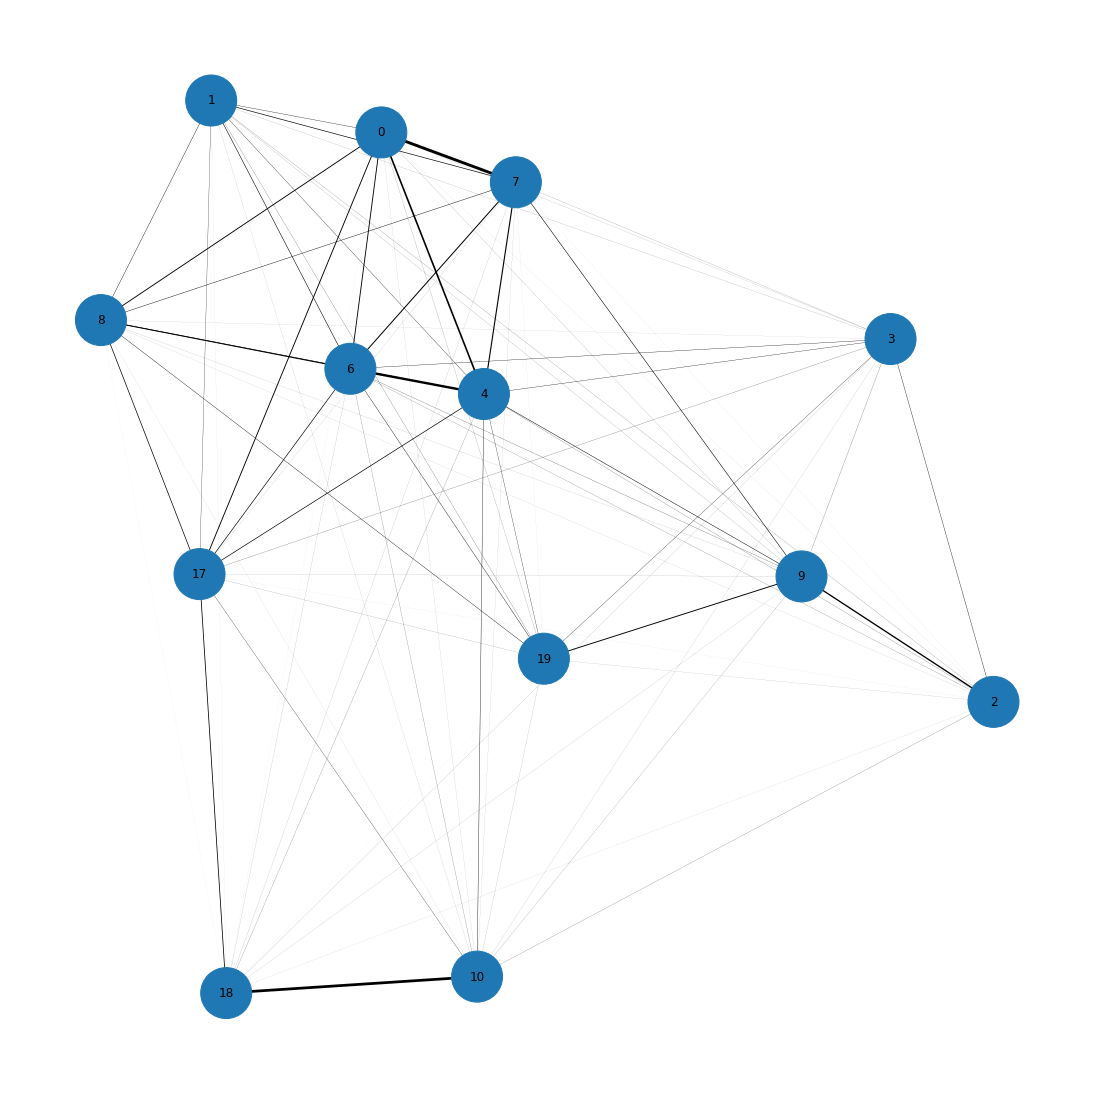

In [197]:
G = create_graph_from_time(RFID, 'i', 'j', RFID.DateTime.min(),  RFID.DateTime.max())
draw_graph(G, factor=2000)

In [213]:
def beautiful_scatter(xs, ys, color, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    plt.scatter(xs, ys, color=color, edgecolors='black', s=35)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

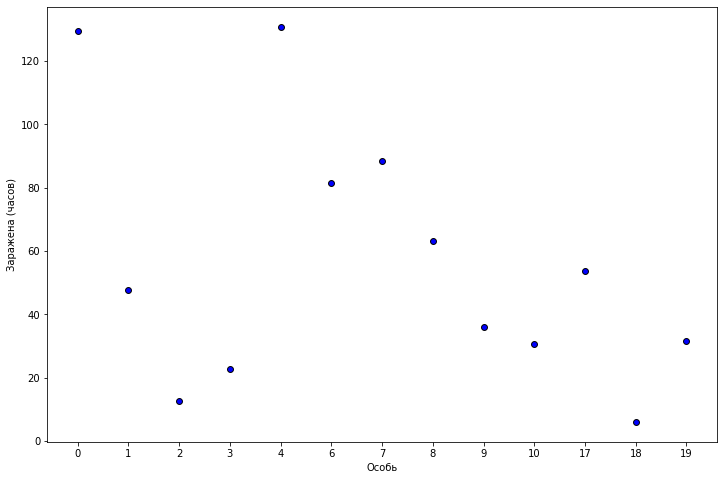

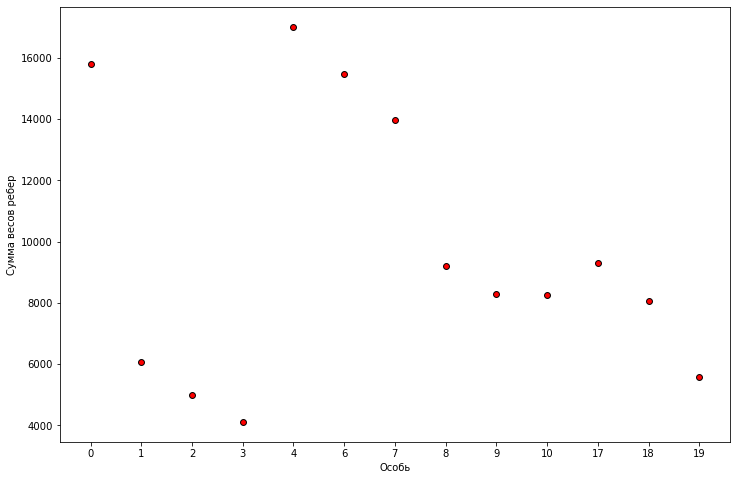

In [214]:
infected_time_means = []
degree_sums = []
for name in names:
    infected_time_means.append(df_SI[f'{name}_total_infected_time'].mean() / 3600)
    degree_sums.append(RFID[(RFID['i'] == name) | (RFID['j'] == name)].shape[0])

beautiful_scatter([str(name) for name in names], infected_time_means, 'blue', 'Особь', 'Заражена (часов)')
beautiful_scatter([str(name) for name in names], degree_sums, 'red', 'Особь', 'Сумма весов ребер')

**Графики очень похожи и это не просто так! Теперь посмотрим (для всех) на зависимость длительности эпидемии от вероятности заражения**

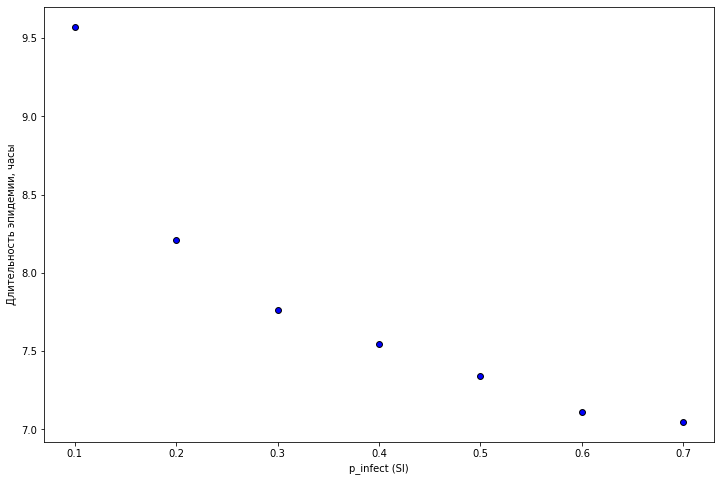

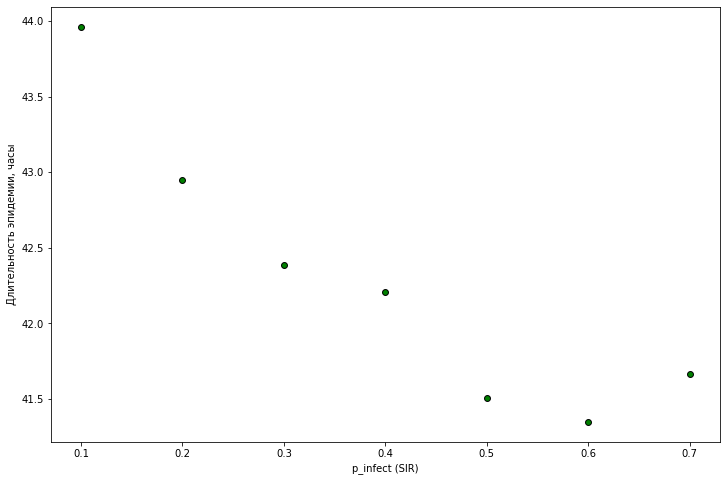

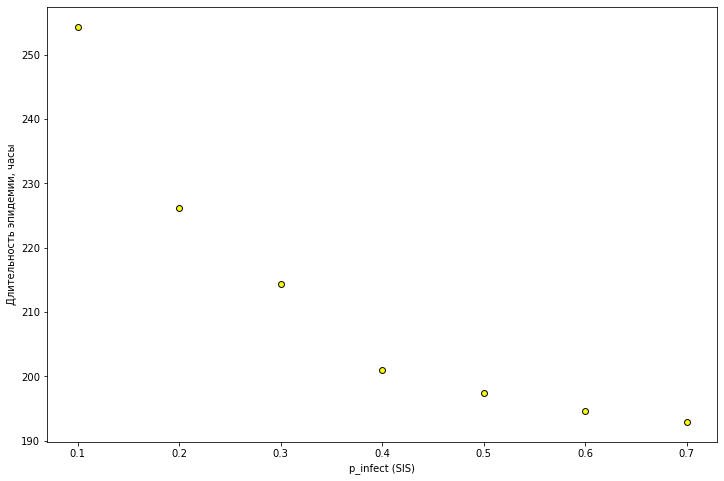

In [215]:
beautiful_scatter(df_SI.groupby(['p_infect'])['duration'].mean().index,
                  df_SI.groupby(['p_infect'])['duration'].mean() / 3600,
                  'blue',
                  'p_infect (SI)',
                  'Длительность эпидемии, часы')

beautiful_scatter(df_SIR.groupby(['p_infect'])['duration'].mean().index,
                  df_SIR.groupby(['p_infect'])['duration'].mean() / 3600,
                  'green',
                  'p_infect (SIR)',
                  'Длительность эпидемии, часы')

beautiful_scatter(df_SIS.groupby(['p_infect'])['duration'].mean().index,
                  df_SIS.groupby(['p_infect'])['duration'].mean() / 3600,
                  'yellow',
                  'p_infect (SIS)',
                  'Длительность эпидемии, часы')

**Во-первых, эпидемии SIR длиннее эпидемий SI, а эпидемии SIS длиннее эпидемий SIR. Впрочем, это очевидно. Во-вторых, увеличение вероятности заражения уменьшает длительность эпидемии во всех трех случаях. И если в первых двух это понятно, то с третьим неочевидно - эпидемия не заканчивается, когда все заражены.**

**Перейдем к SIR**

In [220]:
df_SIR['is_finished'].value_counts()

True    4550
Name: is_finished, dtype: int64

**Эти эпидемии тоже все закончились**

In [239]:
groups = df_SIR.groupby(['p_infect', 'exp_recover_time'])[['healthy_cnt', 'recovered_cnt']].mean()

In [240]:
all_times = pd.DataFrame(groups.reset_index()).to_numpy()

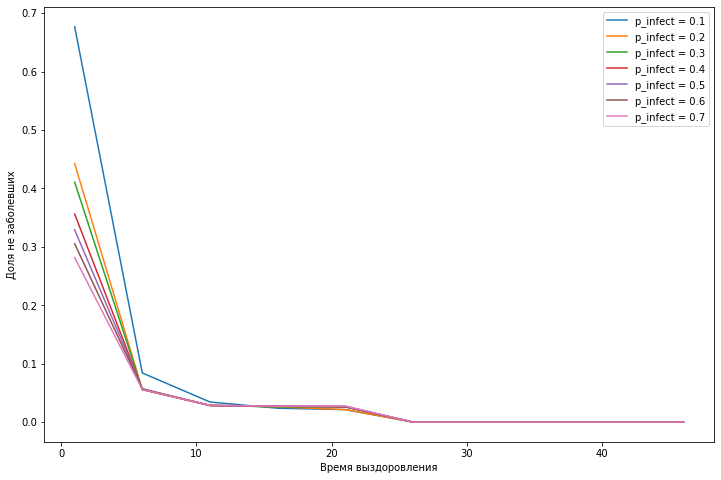

In [244]:
plt.figure(figsize=(12, 8))
for i in range(7):
    xs = all_times[i * 10: (i + 1) * 10, 1] / 3600
    ys = all_times[i * 10: (i + 1) * 10, 2] / 13
    plt.plot(xs, ys, label=f'p_infect = {round((i + 1) * 0.1, 1)}')
plt.legend()
plt.xlabel('Время выздоровления')
plt.ylabel('Доля не заболевших')
plt.show()

**Здесь мы видим графики для разных вероятностей заражения при контакте зависимости доли не заболевших от времени на выздоровление. Различаясь вначале, когда особь болеет 1 час, уже к 6 часам вероятность становится неважна - слишком много контактов. А после 26 часов не заболевших не остается**

**Посмотрим, кто эти не заболевшие герои**

In [245]:
for name in names:
    print(name, df_SIR[df_SIR[f'{name}_status'] == 'h'].shape[0])

0 162
1 202
2 341
3 241
4 165
6 167
7 265
8 237
9 170
10 267
17 198
18 582
19 203


**Как обычно - чаще не заражаются малоконтактные, реже - популярные**

In [246]:
groups = df_SIS.groupby(['p_infect', 'exp_recover_time'])[['healthy_cnt', 'infected_cnt']].mean()
all_times = pd.DataFrame(groups.reset_index()).to_numpy()

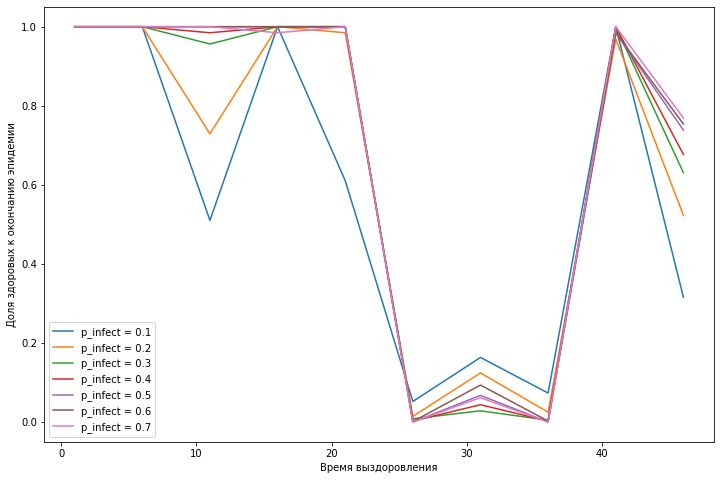

In [250]:
plt.figure(figsize=(12, 8))
for i in range(7):
    xs = all_times[i * 10: (i + 1) * 10, 1] / 3600
    ys = all_times[i * 10: (i + 1) * 10, 2] / 13
    plt.plot(xs, ys, label=f'p_infect = {round((i + 1) * 0.1, 1)}')
plt.legend()
plt.xlabel('Время выздоровления')
plt.ylabel('Доля здоровых к окончанию эпидемии')
plt.show()

**Этот график выглядит необъяснимым, хотя, кажется, не является ошибочным**

In [257]:
df_SIS['is_finished'].value_counts()

True     2956
False    1594
Name: is_finished, dtype: int64

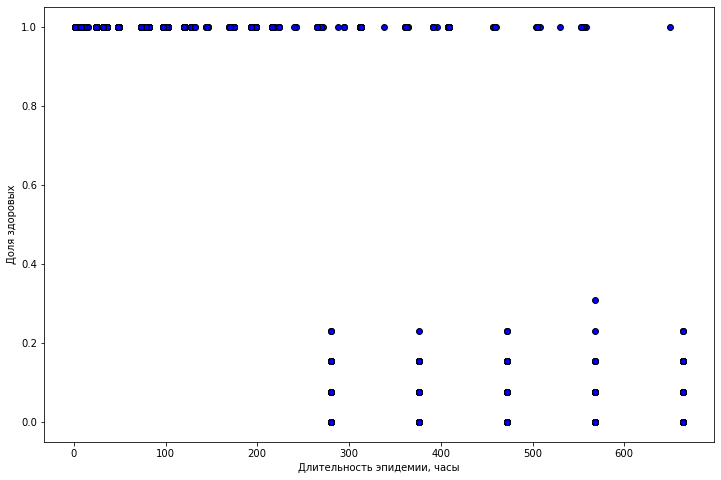

In [258]:
beautiful_scatter(df_SIS['duration'] / 3600, df_SIS['healthy_cnt'] / 13, 'blue', 'Длительность эпидемии, часы', 'Доля здоровых')

**С этим графиком понятно. Наверху, где доля здоровых 1 - это эпидемии, которые закончились до окончания датасета. Внизу, где доля меньше, это эпидемии, которые закончились с окончанием датасета (а третьего варианта и нет), и поэтому их длительность равна времени конца датасета минут один из пяти стартов. Такие четкие точки по вертикали тоже объяснимы, ведь доля здоровых считается из 13 и тут все дискретно. Так что здесь все нормально.**

In [266]:
RFID.head()

,t,i,j,DateTime
0,1560396500,1,6,2019-06-13 05:28:00
1,1560396500,1,19,2019-06-13 05:28:00
2,1560396520,6,9,2019-06-13 05:28:00
3,1560396540,7,0,2019-06-13 05:29:00
4,1560396540,1,6,2019-06-13 05:29:00


In [268]:
hours = [x.hour for x in RFID.DateTime]
Counter(hours)

Counter({5: 1321,
         6: 5692,
         7: 6550,
         8: 6028,
         9: 4091,
         10: 2699,
         11: 2996,
         12: 3185,
         13: 2969,
         14: 3363,
         15: 4003,
         16: 3299,
         17: 1808,
         18: 3104,
         19: 4934,
         20: 4933,
         21: 2064,
         3: 1,
         22: 55})

**Вот в чем дело! Обезьяны ночью спят и не контактируют, что и позволяет выздороветь.**